# Memfilter dan Mengategorikan Kategori Film

Film Junky Union, sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengategorikan ulasan film. Misi utamanya adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Anda akan menggunakan *dataset* ulasan film IMBD dengan pelabelan polaritas untuk membuat sebuah model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya harus memiliki skor F1 sebesar 0,85.

## Inisialisasi

In [1]:
import math

import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI 

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# ini untuk menggunakan progress_apply, baca lebih lanjut di https://pypi.org/project/tqdm/ #pandas-integration
tqdm.pandas()

## Memuat data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

Dataset berisi kolom-kolom berikut:

* tconst — ID unik untuk setiap entitas di basis data IMDb.
* title_type — tipe judul entitas (misalnya, film, serial TV, dll.).
* primary_title — judul utama dari entitas.
* original_title — judul asli dari entitas (misalnya, judul dalam bahasa asli).
* start_year — tahun mulai perilisan entitas.
* end_year — tahun akhir perilisan (jika berlaku), atau tanda khusus jika entitas masih berlanjut.
* runtime_minutes — durasi entitas dalam menit.
* is_adult — indikator apakah entitas termasuk konten dewasa (1 untuk ya, 0 untuk tidak).
* genres — genre-genre yang terkait dengan entitas (dipisahkan oleh koma).
* average_rating — rata-rata nilai peringkat entitas.
* votes — jumlah suara atau ulasan yang diterima oleh entitas.
* review — ulasan atau tinjauan terkait entitas.
* rating — nilai peringkat entitas.
* sp — ulasan positif atau ulasan negatif dalam bentuk teks.
* pos — ulasan positif atau ulasan negatif dalam bentuk numerik.
* ds_part — sumber dataset entitas dari train atau test.
* idx — nomor indeks unik yang mewakili baris tertentu dalam dataset.

dataset terdiri dari 17 kolom dengan 47331, terlihat bahwa ada beberapa nilai yang hilang, tapi tidak terlalu banyak, ada kolom dengan tipe data yang salah `runtime_minutes`.

In [7]:
# mengecek nilai yang hilang pada dataset
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [8]:
# mengecek duplikasi dataset
df_reviews.duplicated().sum()

0

In [9]:
df_reviews['runtime_minutes'].unique()

array(['121', '25', '88', '85', '90', '113', '96', '99', '43', '82', '74',
       '100', '95', '129', '60', '92', '98', '104', '94', '116', '102',
       '141', '89', '120', '180', '97', '107', '87', '44', '149', '130',
       '40', '45', '84', '30', '\\N', '70', '126', '110', '93', '80',
       '78', '8', '118', '123', '106', '79', '109', '112', '139', '117',
       '46', '135', '31', '12', '1', '72', '58', '77', '150', '7', '101',
       '91', '138', '10', '108', '105', '61', '69', '152', '47', '65',
       '23', '119', '374', '225', '66', '71', '15', '114', '83', '20',
       '301', '216', '148', '155', '251', '67', '177', '103', '62', '81',
       '111', '140', '125', '122', '124', '76', '146', '42', '50', '400',
       '73', '115', '75', '200', '22', '133', '160', '86', '21', '128',
       '230', '29', '162', '127', '147', '53', '13', '151', '9', '278',
       '179', '63', '137', '59', '165', '1140', '263', '54', '143', '183',
       '131', '51', '157', '132', '64', '57', '11', '4

dikarenakan ada baris yang memiliki nilai `\\N` sehingga sedikit sulit untuk mengganti tipe datanya untuk saat ini mari kita biarkan dulu.

In [10]:
df_reviews['ds_part'].value_counts()

train    23796
test     23535
Name: ds_part, dtype: int64

In [11]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


**Kesimpulan:** dataset terdiri dari 17 kolom dengan 47331, terlihat bahwa ada beberapa nilai yang hilang, tapi tidak terlalu banyak, ada kolom dengan tipe data yang salah `runtime_minutes`. tipe data pada kolom `runtime_minutes` tidak dapat langsung diubah karena memiliki nilai `\\N` yang sulit di definisikan

## EDA

Periksa jumlah film dan ulasan selama beberapa tahun.

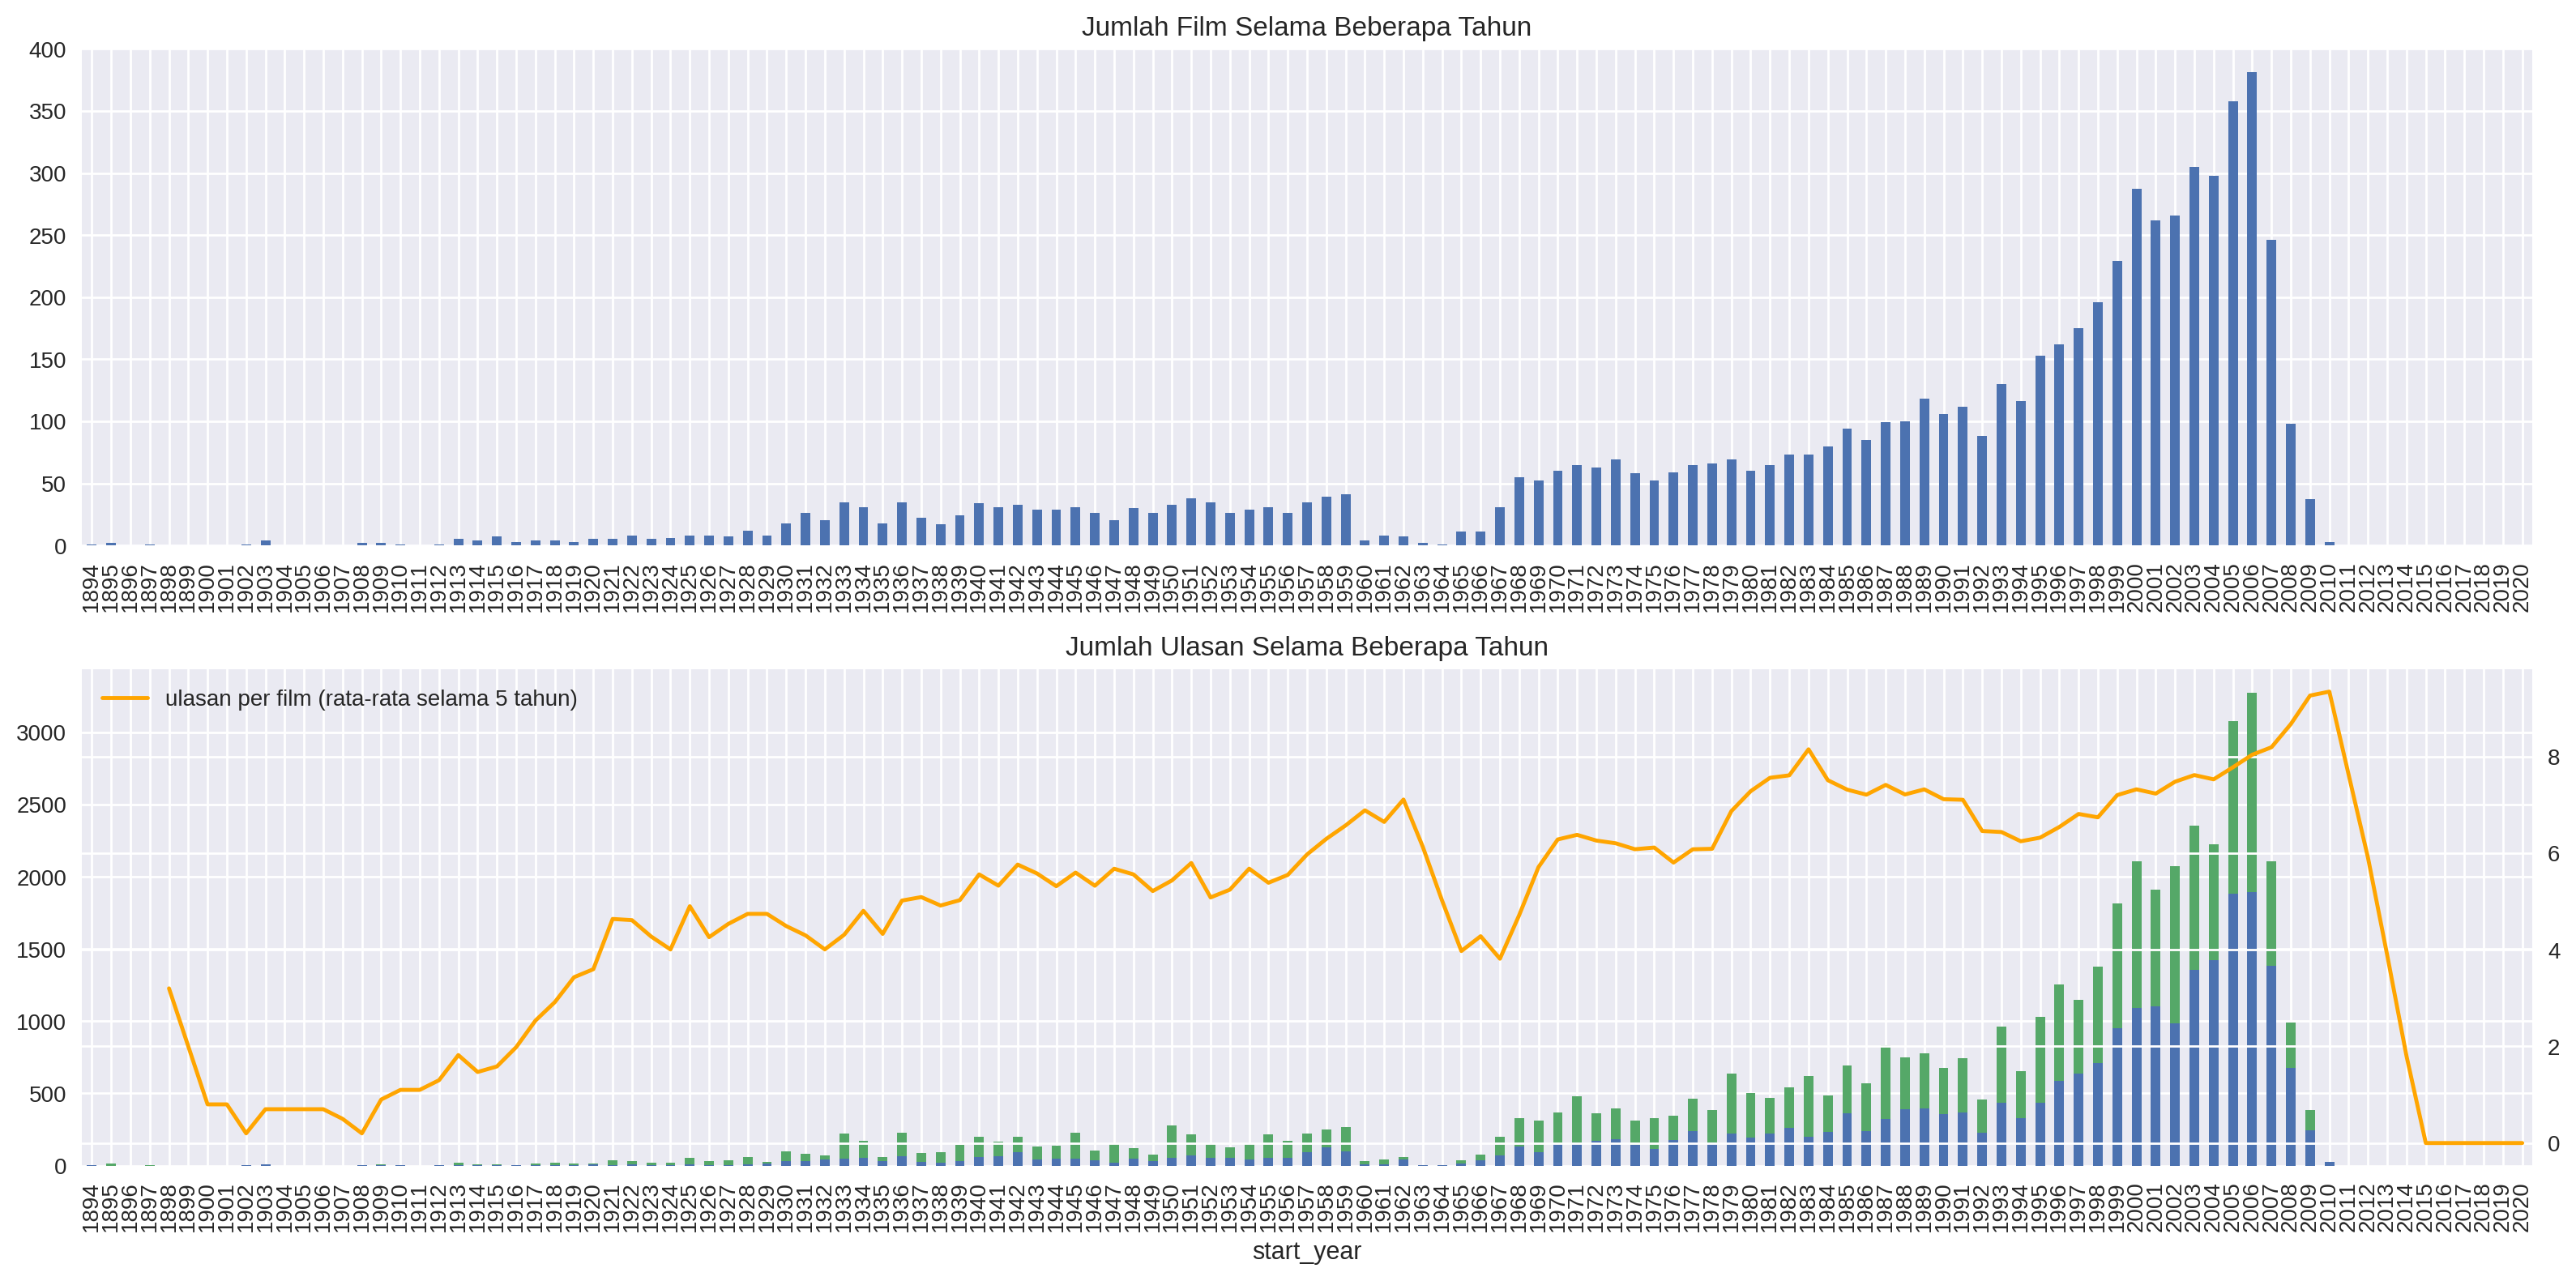

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 

fig.tight_layout()

Berdasarkan grafik diatas kita dapat menyimpulkan bahwa hampir setiap tahun mengalami peningkatan jumlah film yang diikuti dengan meningkatnya jumlah ulasan terhadap film tersebut dengan perbandingan ulasan positif dan ulasan negatif. Puncak rata-rata tertinggi tahun 2010 yang mencapai lebih dari 3000 ulasan.

Periksa distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE (hanya untuk mengetahui perbedaannya dari penghitungan yang tepat)

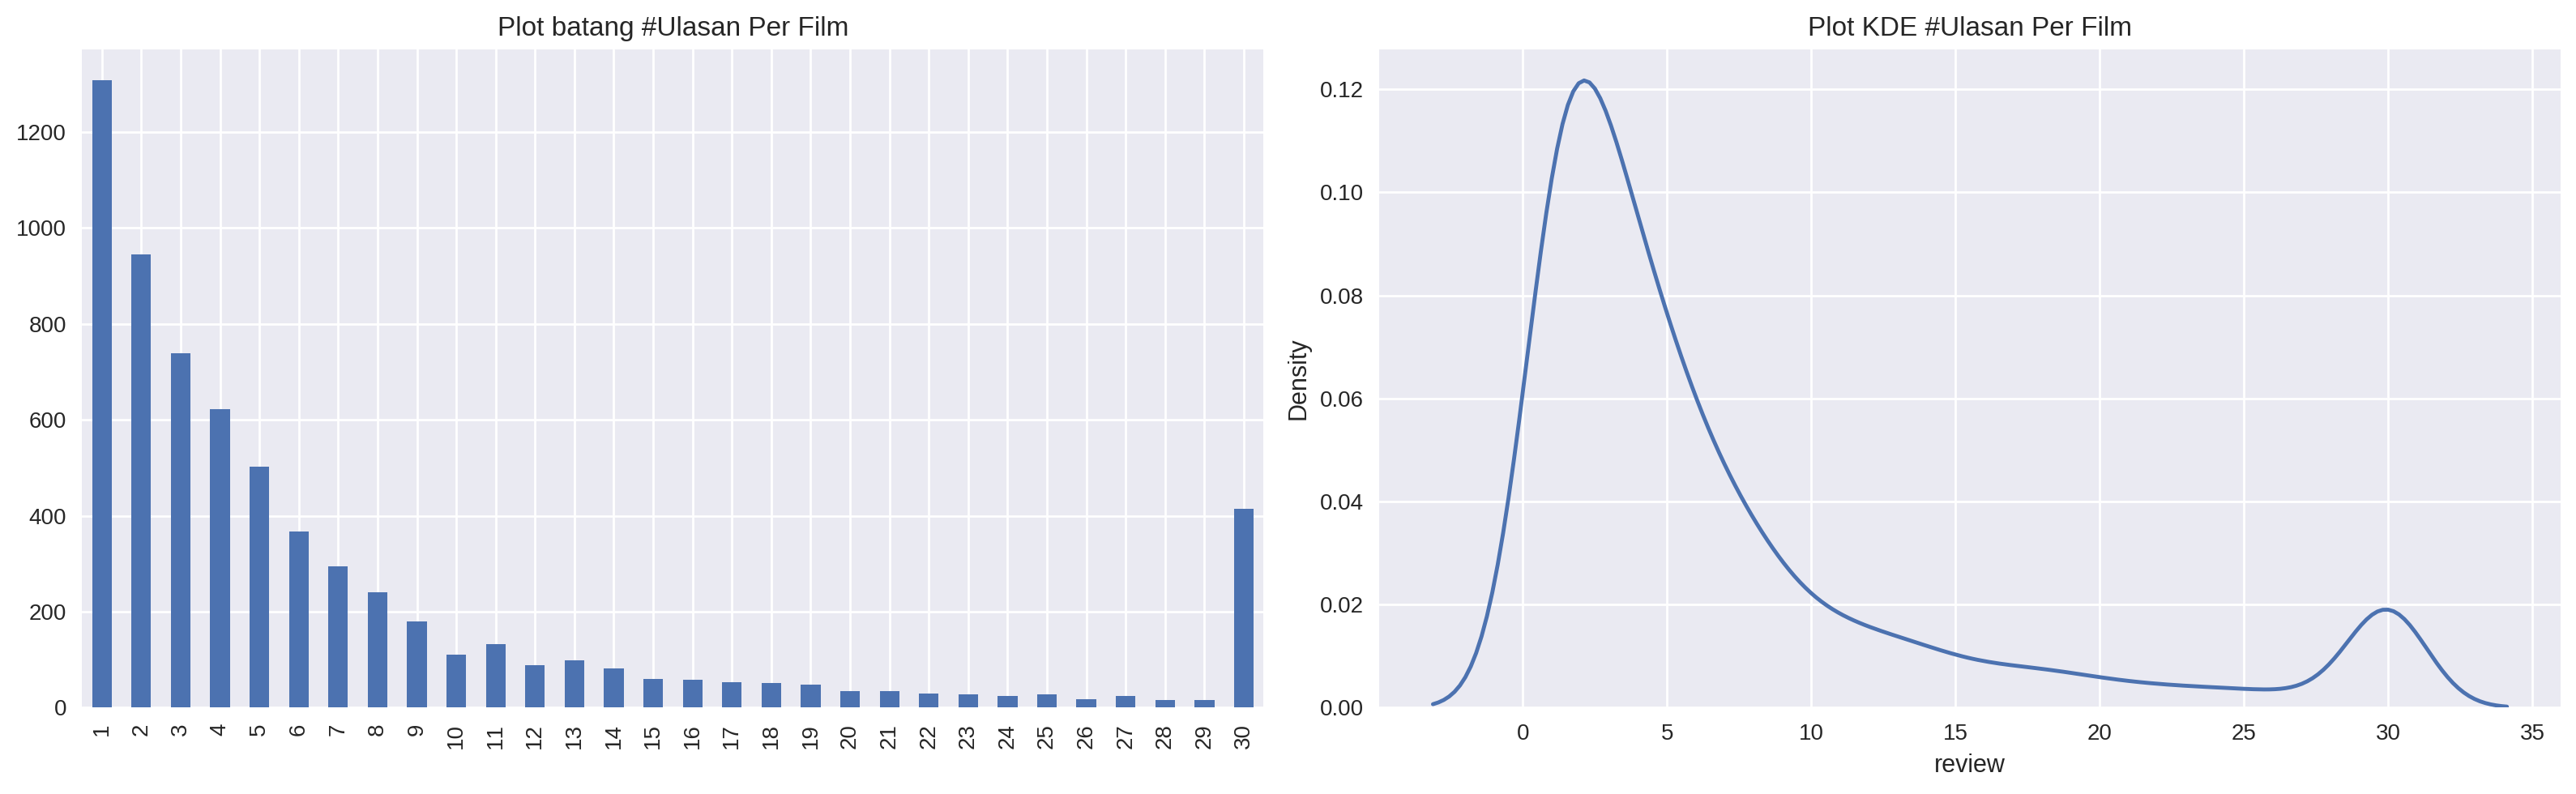

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film')

fig.tight_layout()

Berdasarkan grafik diatas rata-rata film kebanyakan memiliki ulasan sebanyak 1-5 ulasan/film, kemudian diikuti dengan film yang memiliki ulasan sebanyak 30 ulasan/film dan disusul setelahnya.

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

terlihat bahwa ulasan positif dan negatif hampir seimbang

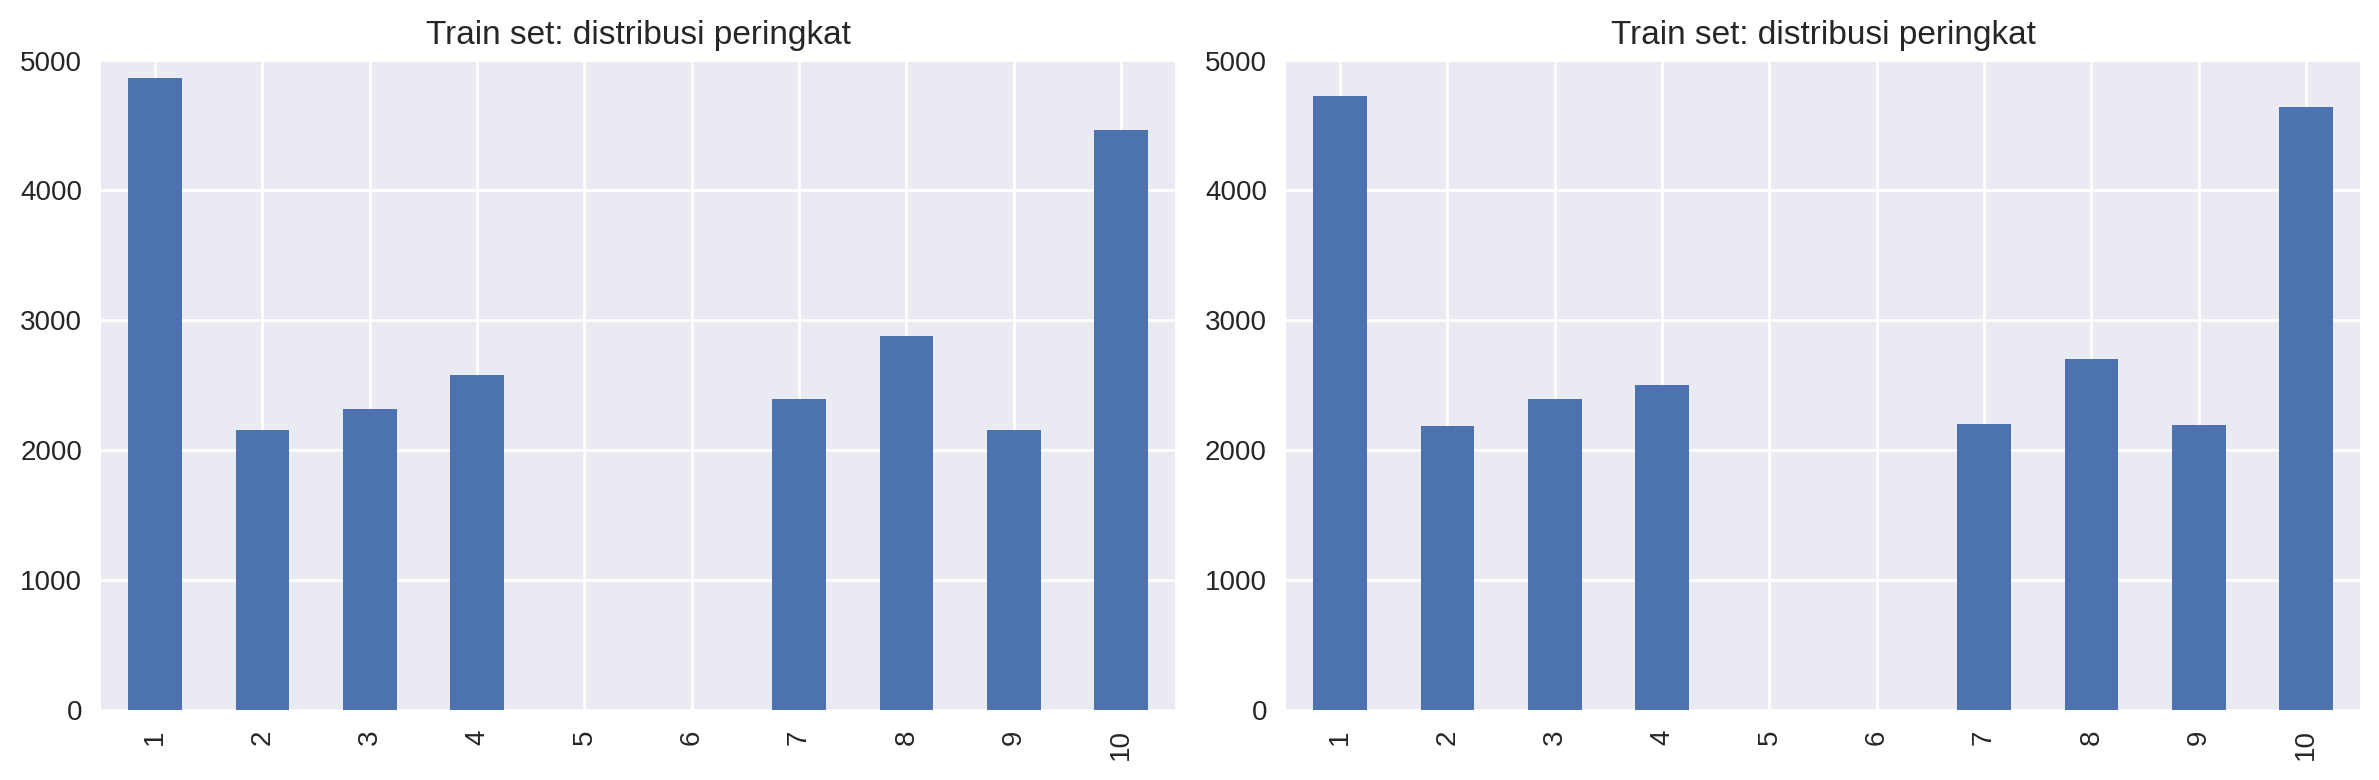

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

fig.tight_layout()

Disini kita juga bisa melihat perbadingan jumlah rating film yang seimbang, baik untuk dataset training maupun dataset test. Bisa terlihat jumlah rating terbanyak adalah 1 dan 10 untuk kedua dataset.

Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian *dataset*

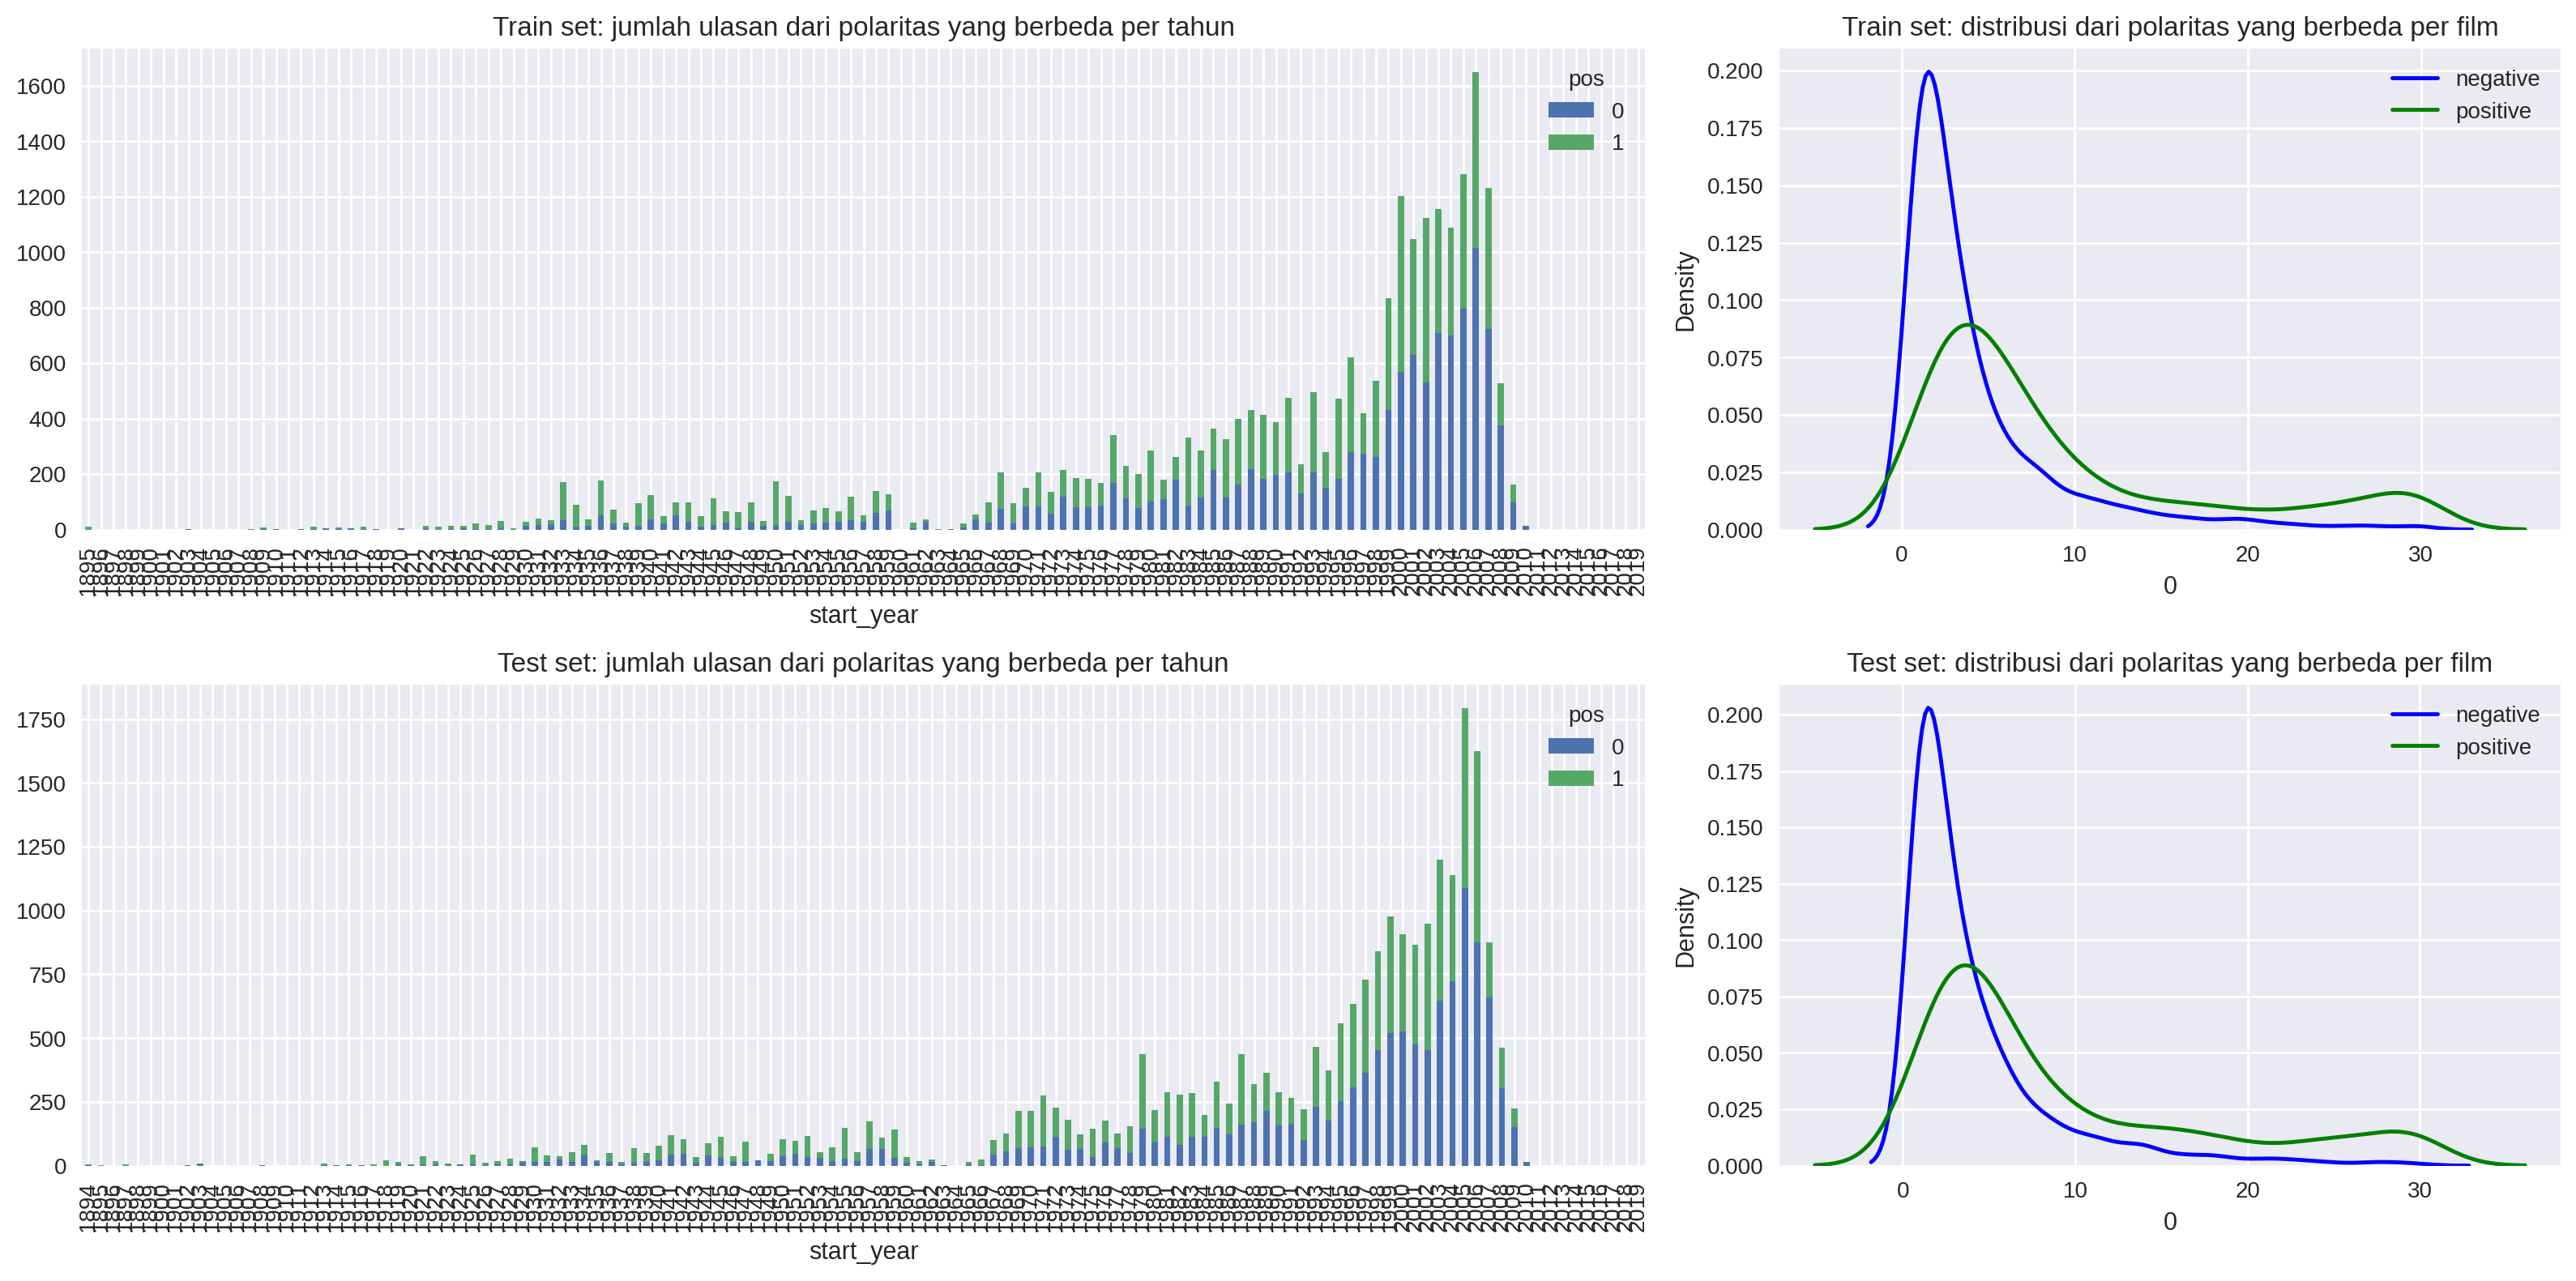

In [16]:
# membuat plot komparasi jumlah ulasan (negatif [0] dan positif[1]) berdasarkan dataset training dan test
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Train set: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Test set: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

Disini bisa kita lihat bentuk dataset training dan test memiliki kemiripan berdasarkan jumlah ulasan positif dan jumlah ulasan negatif. Perbandingan jumlah ulasan positif dan jumlah ulasan negatif yang hampir seimbang untuk masing-masing dataset. Hal tersebut kita bisa langsung menggunakan dataset ini sebagai model latih dan uji pada model-model yang akan kita gunakan tanpa perlu adanya filtering data.

**Kesimpulan:** dataset memperlihatkan bahwa setiap tahun terjadi peningkatan perilisan dan review dari film. kritik yang dihasilkan beragam, secara nilai positif dan negatif memiliki nilai kesetimbangan yang sama. dataset train dan test pun seimbang antara positif dan negatif, sehingga lebih memudahkan untuk proses selanjutnya.

## Prosedur Evaluasi

Menyusun evaluasi yang dapat digunakan untuk semua model dalam tugas ini secara rutin

In [17]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Kurva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalisasi

Kita menganggap semua model di bawah menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll.

In [18]:
# sampel sebelum dilakukan normalisasi
df_reviews['review'][1]

'How the hell did they get this made?! Presenting itself as a caper comedy, the misbegotten "$" is essentially two hours of people mumbling sentence fragments. The usually dependable Warren Beatty looks drunk, and the usually hilarious Goldie Hawn acts like she\'s on depressants. As for Gert Frobe, his most famous role - Goldfinger - was infinitely more admirable than his character here. Not even the guy with the champagne bottle of LSD can save this litany of worthlessness. Am I comparing this movie to "Plan 9 from Outer Space"? I wouldn\'t do such a thing even if someone paid me. "P9FOS" was idiotically made but ended up hilarious; this was idiotically made and causes you to feel like your brain just melted out of your ears. Warren Beatty and Goldie Hawn made up for this when they co-starred in "Shampoo", but then they co-starred in the dreadful "Town & Country". Maybe they just shouldn\'t co-star in movies. All in all, I would rather have my skin torn off than have to watch this aga

terlihat bahwa data memiliki huruf besar kecil dan beberapa tanda baca yang akan menyulitkan proses selanjutnya, untuk mempermudah proses selanjutnya mari kita seragamkan terlebih dahulu kolom ini

In [19]:
# mendefinisikan fungsi untuk menghilangkan angka, tanda baca dan sebagainya
def pre_text(text):
    # mengecilkan huruf dari masing-masing kata
    text = text.lower()
    # mengekstrak kata dengan menghilangkan angka dan tanda baca
    pattern = r"[^a-z\s]"
    text = re.sub(pattern, " ", text)
    text = text.split()
    return ' '.join(text)

def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern,' ',text)
    text = text.split()
    text = " ".join(text).lower()
    return text

# menerapkan fungsi yang sudah dibuat
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)

In [20]:
# sampel setelah dilakukan normalisasi
df_reviews['review_norm'][1]

"how the hell did they get this made presenting itself as a caper comedy the misbegotten is essentially two hours of people mumbling sentence fragments the usually dependable warren beatty looks drunk and the usually hilarious goldie hawn acts like she's on depressants as for gert frobe his most famous role goldfinger was infinitely more admirable than his character here not even the guy with the champagne bottle of lsd can save this litany of worthlessness am i comparing this movie to plan from outer space i wouldn't do such a thing even if someone paid me p fos was idiotically made but ended up hilarious this was idiotically made and causes you to feel like your brain just melted out of your ears warren beatty and goldie hawn made up for this when they co starred in shampoo but then they co starred in the dreadful town country maybe they just shouldn't co star in movies all in all i would rather have my skin torn off than have to watch this again awful maybe they should remake it wit

sekarang kolom review sudah di normalisasi sehingga menjadi kecil semua.

## Pemisahan Train / Test

Untungnya, seluruh *dataset* sudah dibagi menjadi *train/test*. Bendera yang sesuai adalah 'ds_part'.

In [21]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [22]:
# mengecek keseimbangkan kelas pada data train
train_target.value_counts()

0    11912
1    11884
Name: pos, dtype: int64

In [23]:
# mengecek keseimbangkan kelas pada data test
test_target.value_counts()

0    11803
1    11732
Name: pos, dtype: int64

terlihat bahwa data train dan test memiliki nilai positif dan negatif yang hampir seimbang. sekarang kita akan memisahkan fiturnya dengan kolom yang sudah di normalisasi.

In [24]:
# memisahkan fitur
x_train = df_reviews_train['review_norm']
x_test = df_reviews_test['review_norm']

In [25]:
x_train.head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
7    this true story of carlson's raiders is more o...
8    should have been titled 'balderdash ' little i...
9    the movie 'gung ho ' the story of carlson's ma...
Name: review_norm, dtype: object

## Bekerja dengan Model

### Model 0 - Konstan

In [26]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


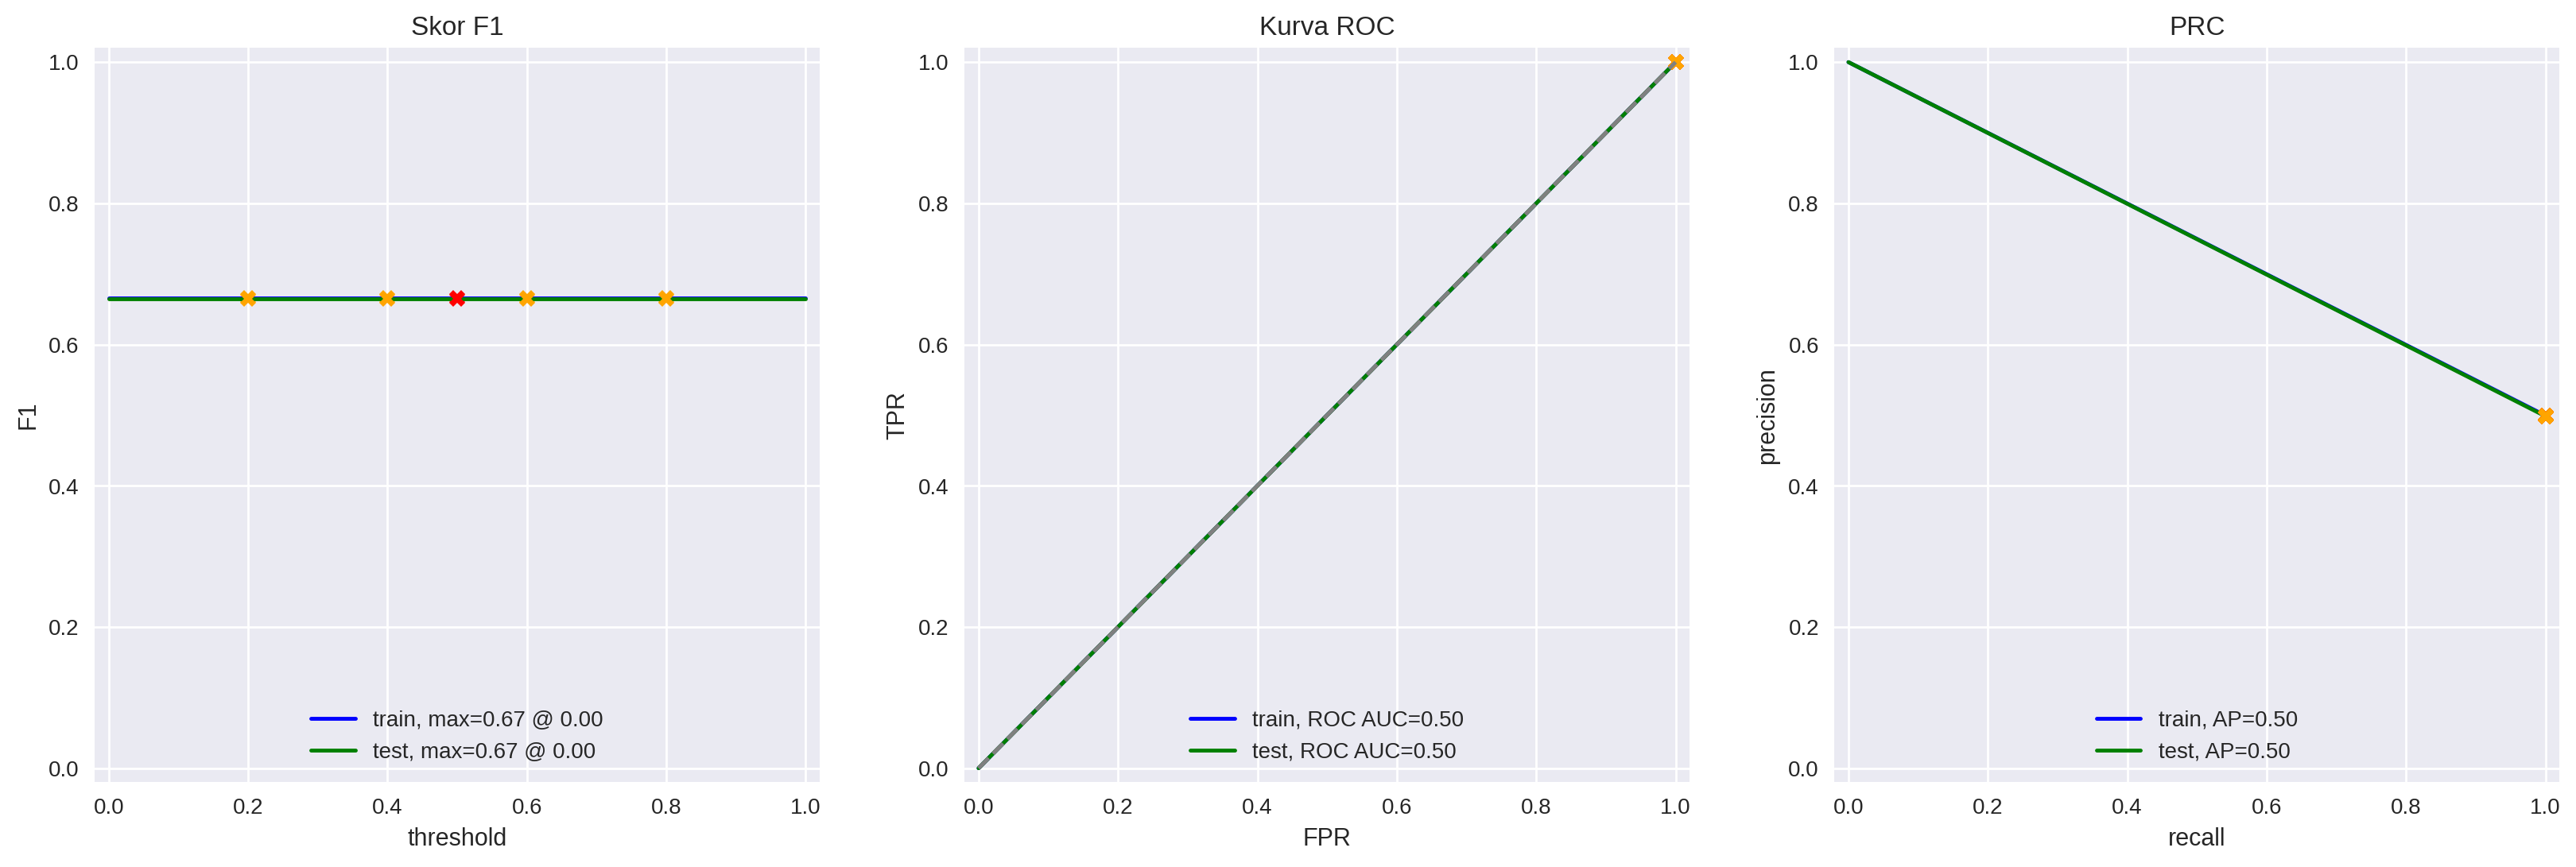

In [27]:
model_dummy = DummyClassifier(strategy='constant', constant=1)
model_dummy.fit(x_train,train_target)

evaluate_model(model_dummy,x_train, train_target,x_test, test_target)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


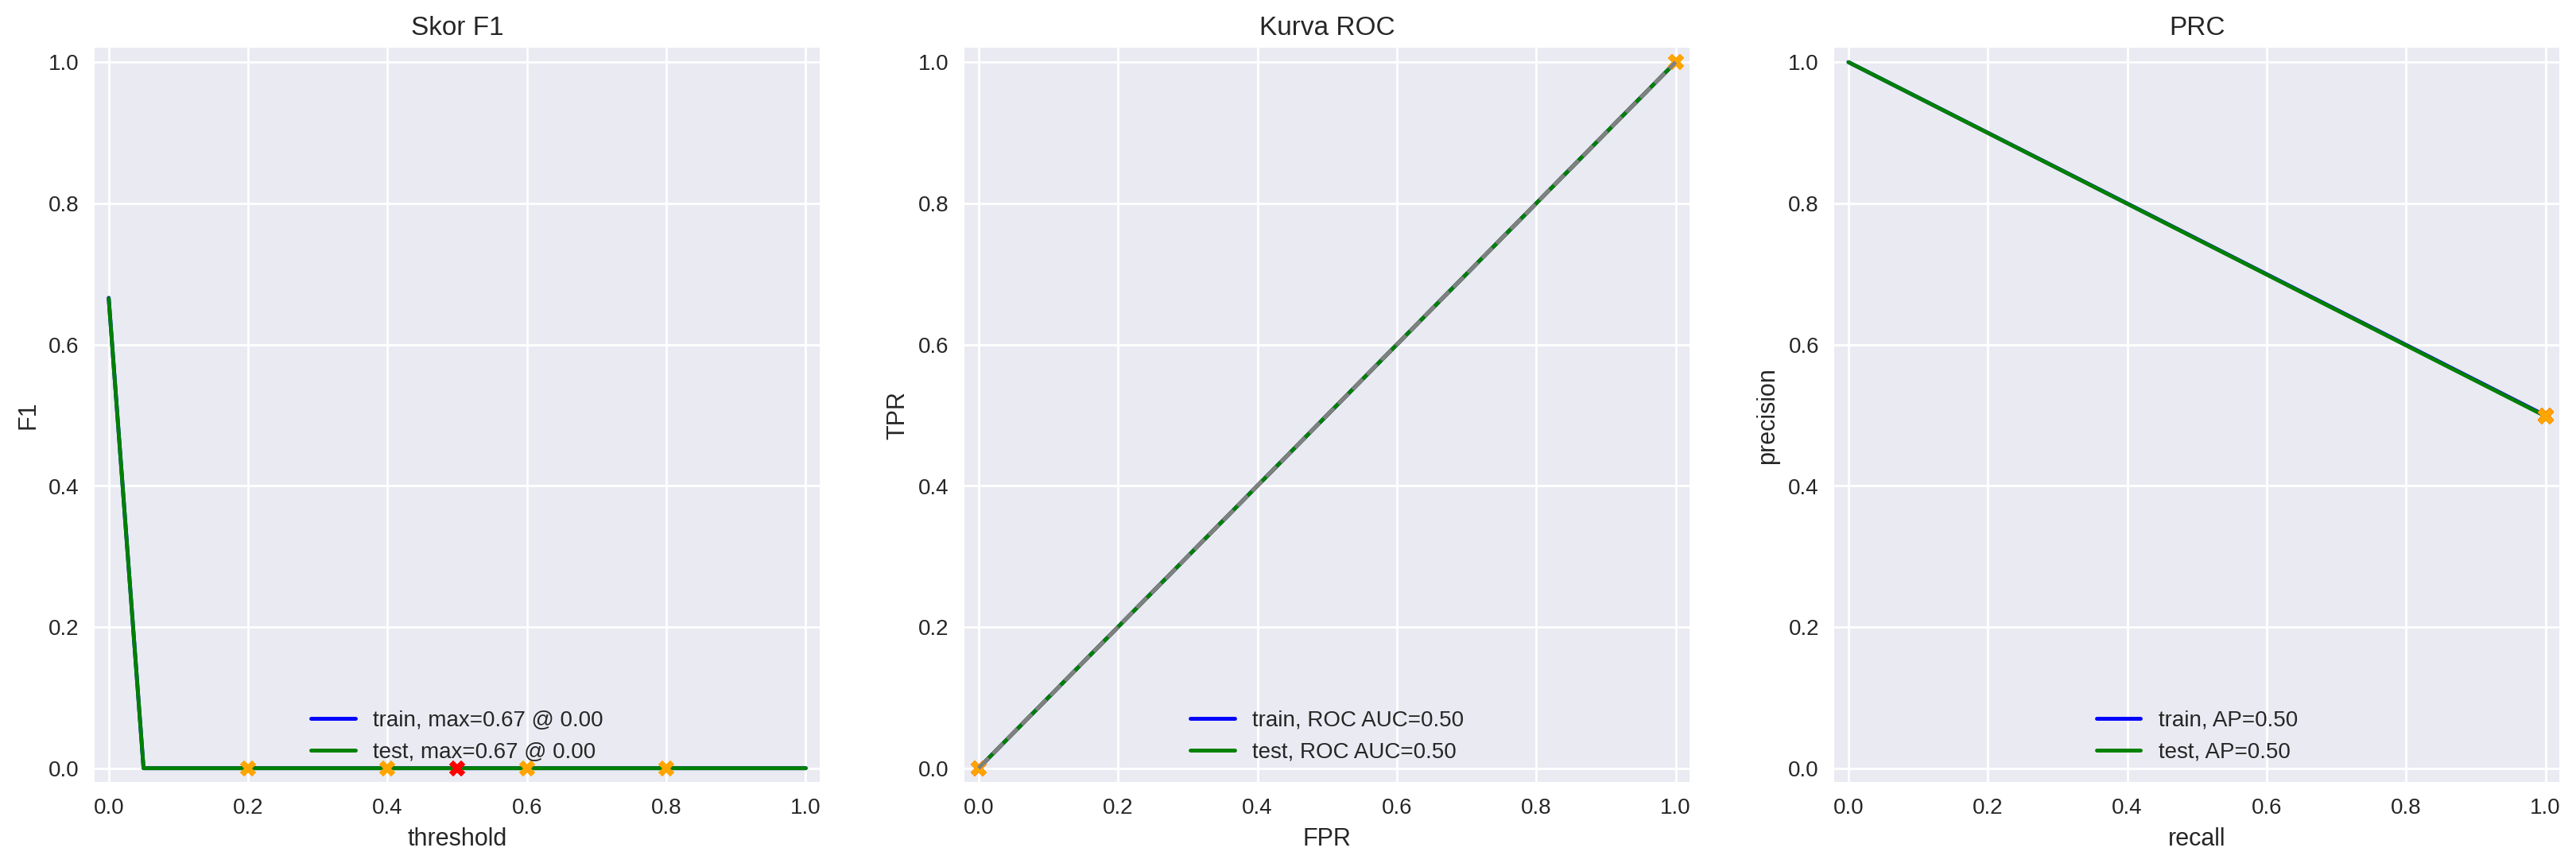

In [28]:
model_dummy = DummyClassifier(strategy='constant', constant=0)
model_dummy.fit(x_train,train_target)

eval_0 = evaluate_model(model_dummy, x_train, train_target, x_test, test_target)

terlihat bahwa nilai secraa keseluruhan memiliki nilai. `const` dengan nilai `0` menghasilkan nilai `F1` sama dengan `0` pula, akan tetapi nilai lainnya konstan `0.5`

### Model 1 - NLTK, TF-IDF dan LR

TF-IDF

In [29]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [30]:
# Menggunakan TfidfVectorizer untuk mentransformasi data teks
tfidf = TfidfVectorizer(stop_words='english')

# Melatih TF-IDF di set pelatihan
train_tfidf = tfidf.fit_transform(x_train)

# Mentransformasi set pengujian
test_tfidf = tfidf.transform(x_test)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


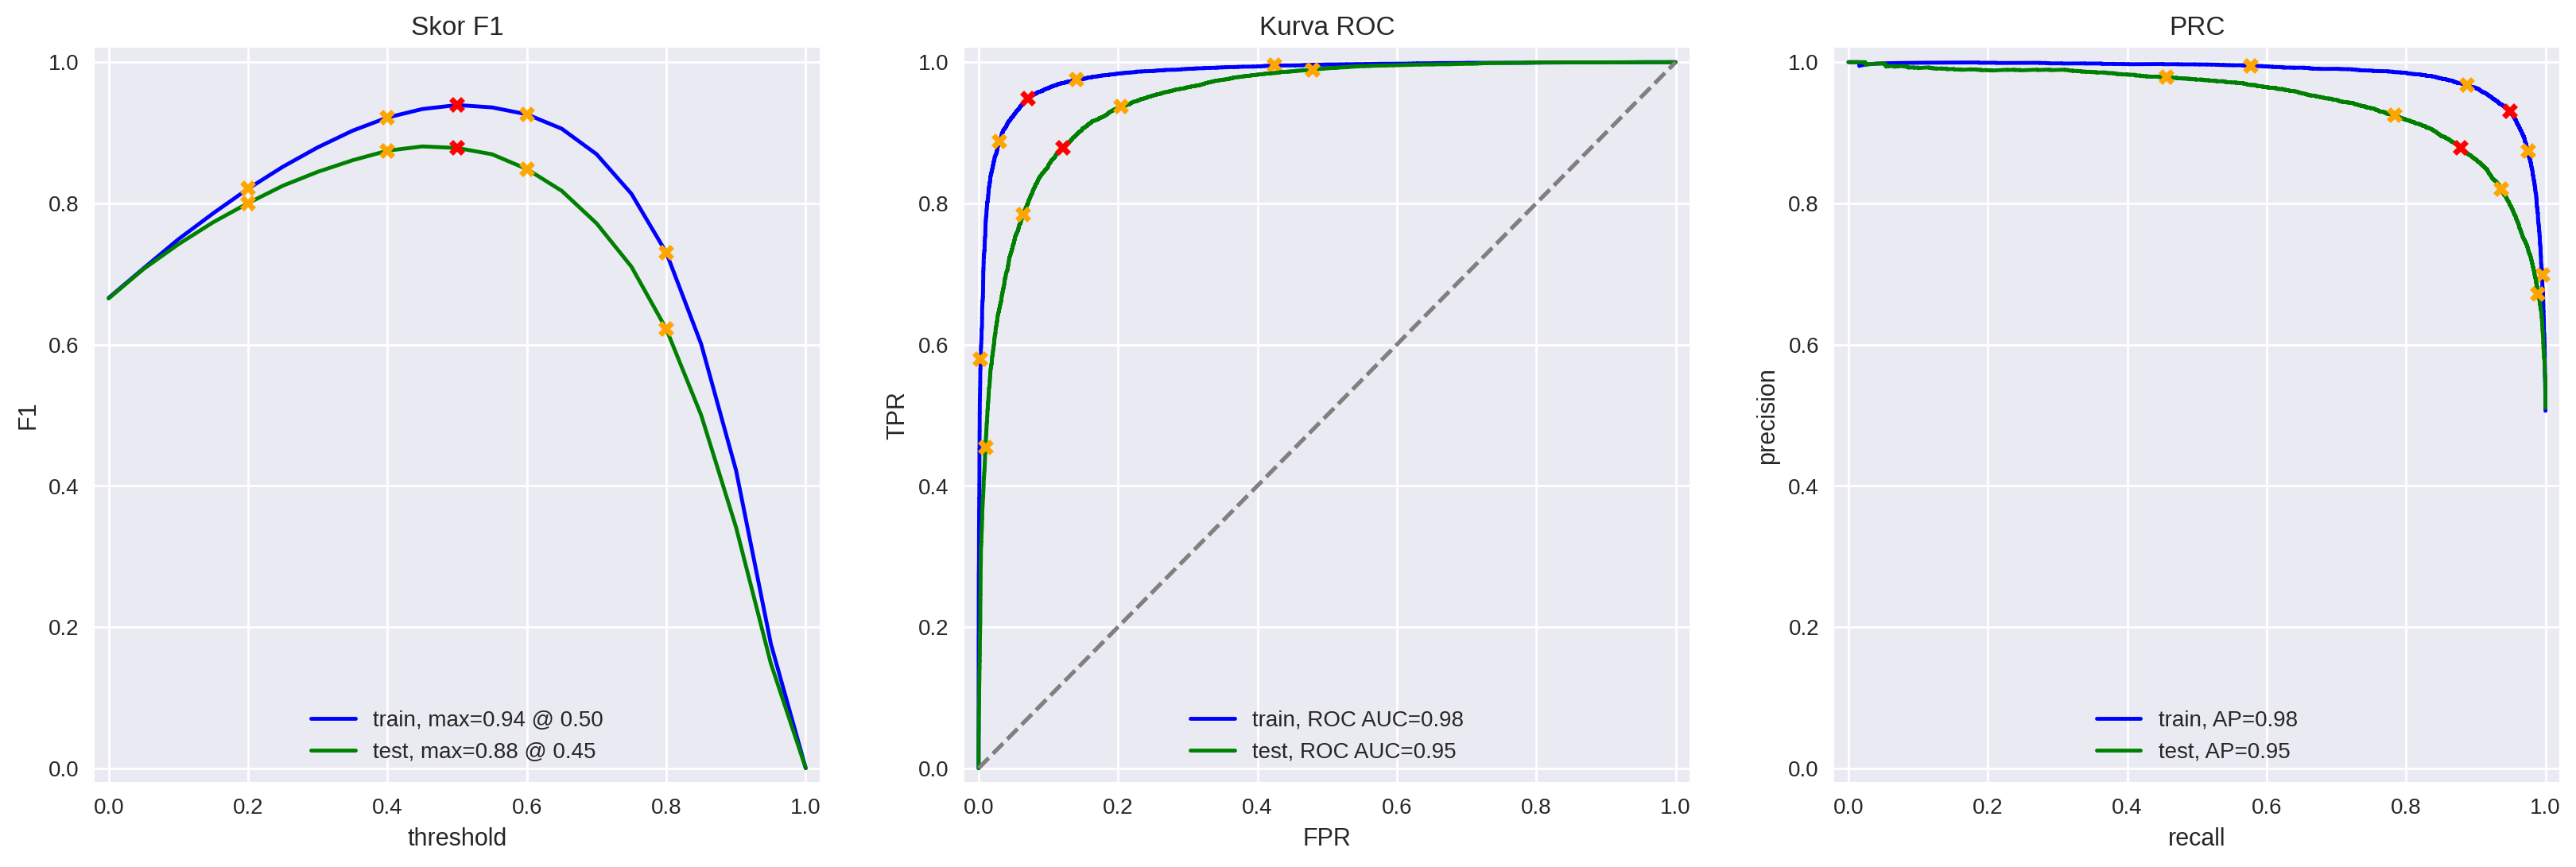

In [31]:
model_lr = LogisticRegression()
model_lr.fit(train_tfidf, train_target)

eval_1 = evaluate_model(model_lr, train_tfidf, train_target, test_tfidf, test_target)

disini nilainya lebih baik daripada sebelumnya, untuk train memiliki rentang nilai `0.94`-`0.98` sedangkan nilai testnya pada rentang `0.88`-`0.95`

### Model 3 - spaCy, TF-IDF dan LR

In [32]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [33]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [34]:
# mendefinisikan modul spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# membuat pra-pemrosesan untuk model-2
def text_preprocessing_2(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# mentransformasi dataset menggunakan fungsi pra-pemrosesan model-2
transformed_train_2 = x_train.apply(text_preprocessing_2)
transformed_test_2 = x_test.apply(text_preprocessing_2)

# melakukan vektoriasi fitur pada masing-masing dataset
tfidf_vectorizer_2 = TfidfVectorizer()
train_features_2 = tfidf_vectorizer_2.fit_transform(transformed_train_2)
test_features_2 = tfidf_vectorizer_2.transform(transformed_test_2)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.94
ROC AUC    0.98  0.95


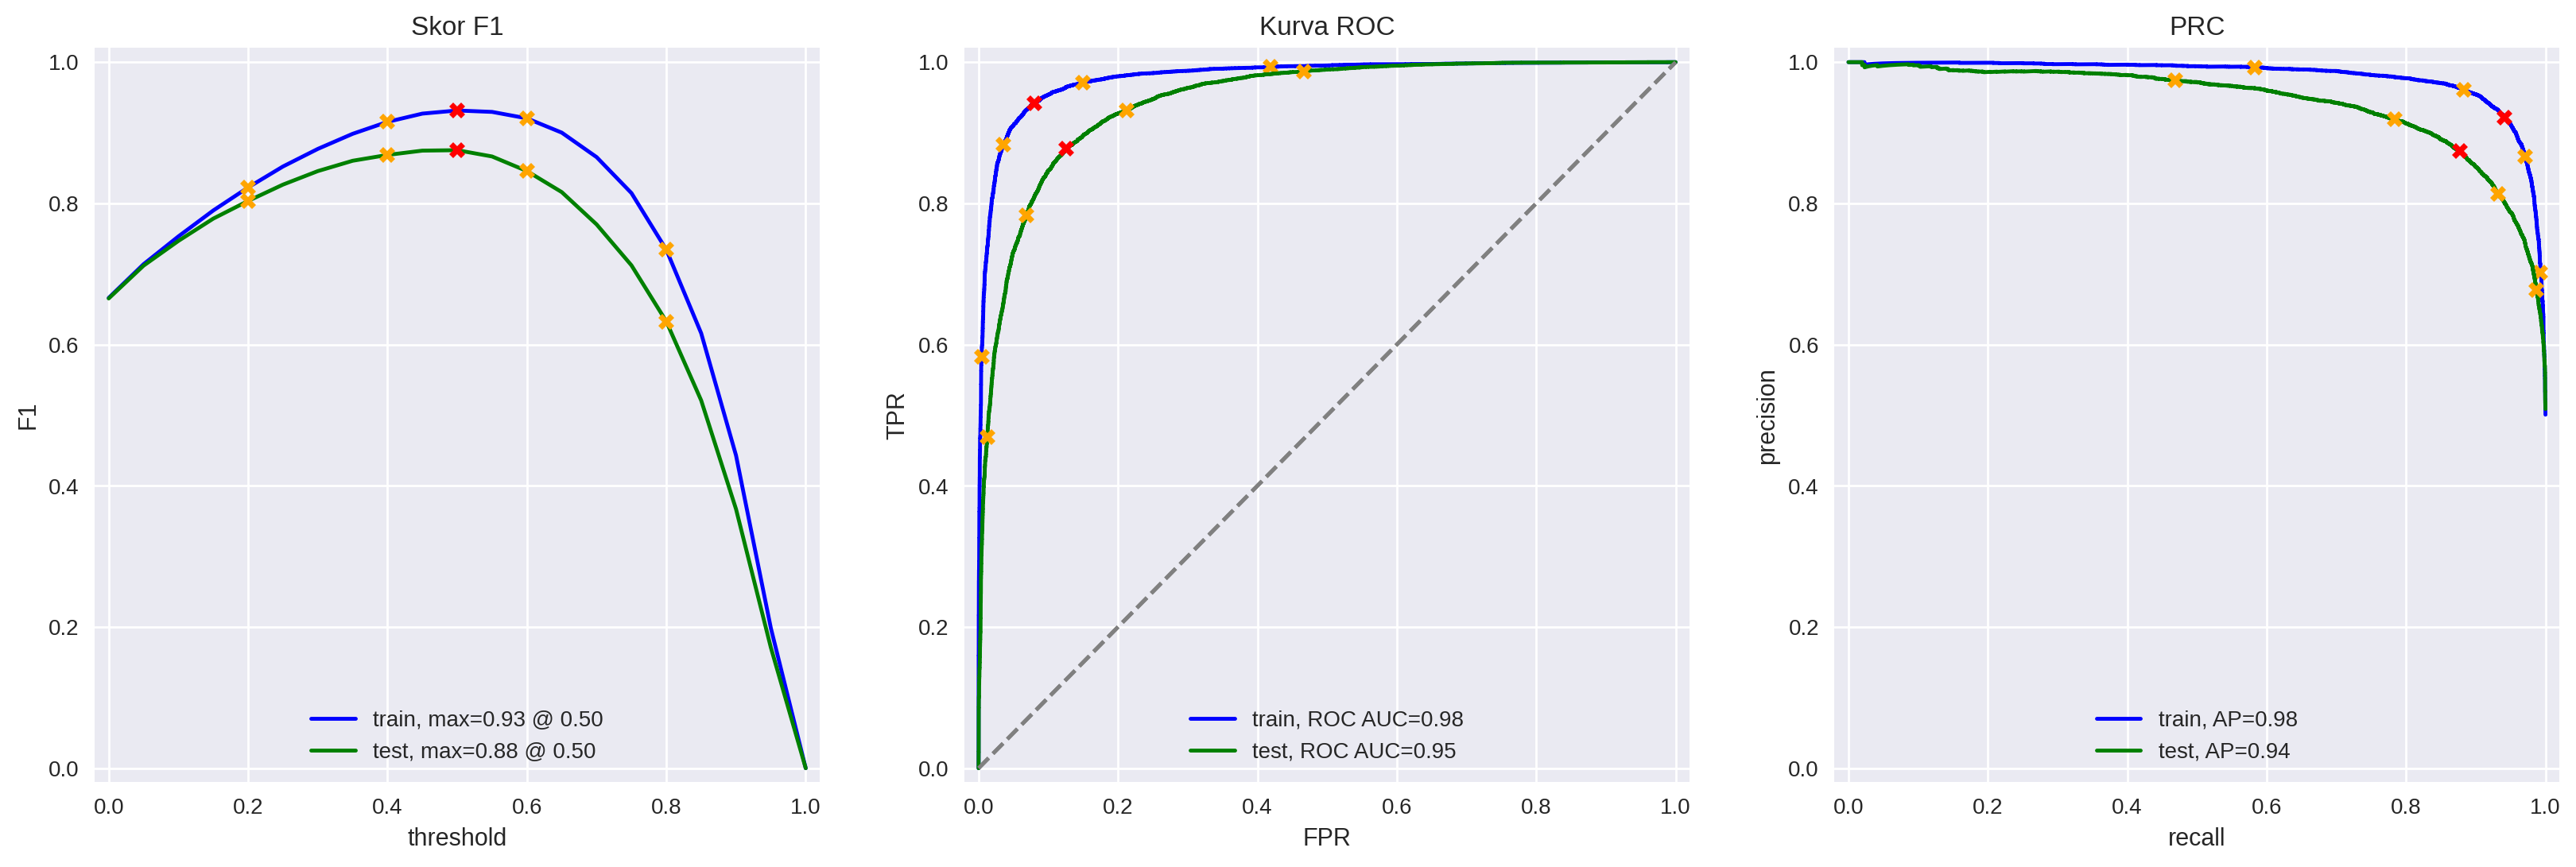

In [35]:
# melatih model logistic regression
model_lr2 = LogisticRegression()
model_lr2.fit(train_features_2,train_target)

# mengevaluasi model-2 logistic regression
eval_3 = evaluate_model(model_lr2, train_features_2, train_target, test_features_2, test_target)

disini nilainya lebih baik daripada sebelumnya, untuk train memiliki rentang nilai `0.93`-`0.98` sedangkan nilai testnya pada rentang `0.88`-`0.95`

### Model 4 - spaCy, TF-IDF dan LGBMClassifier

In [36]:
from lightgbm import LGBMClassifier

          train  test
Accuracy    1.0  0.86
F1          1.0  0.86
APS         1.0  0.94
ROC AUC     1.0  0.94


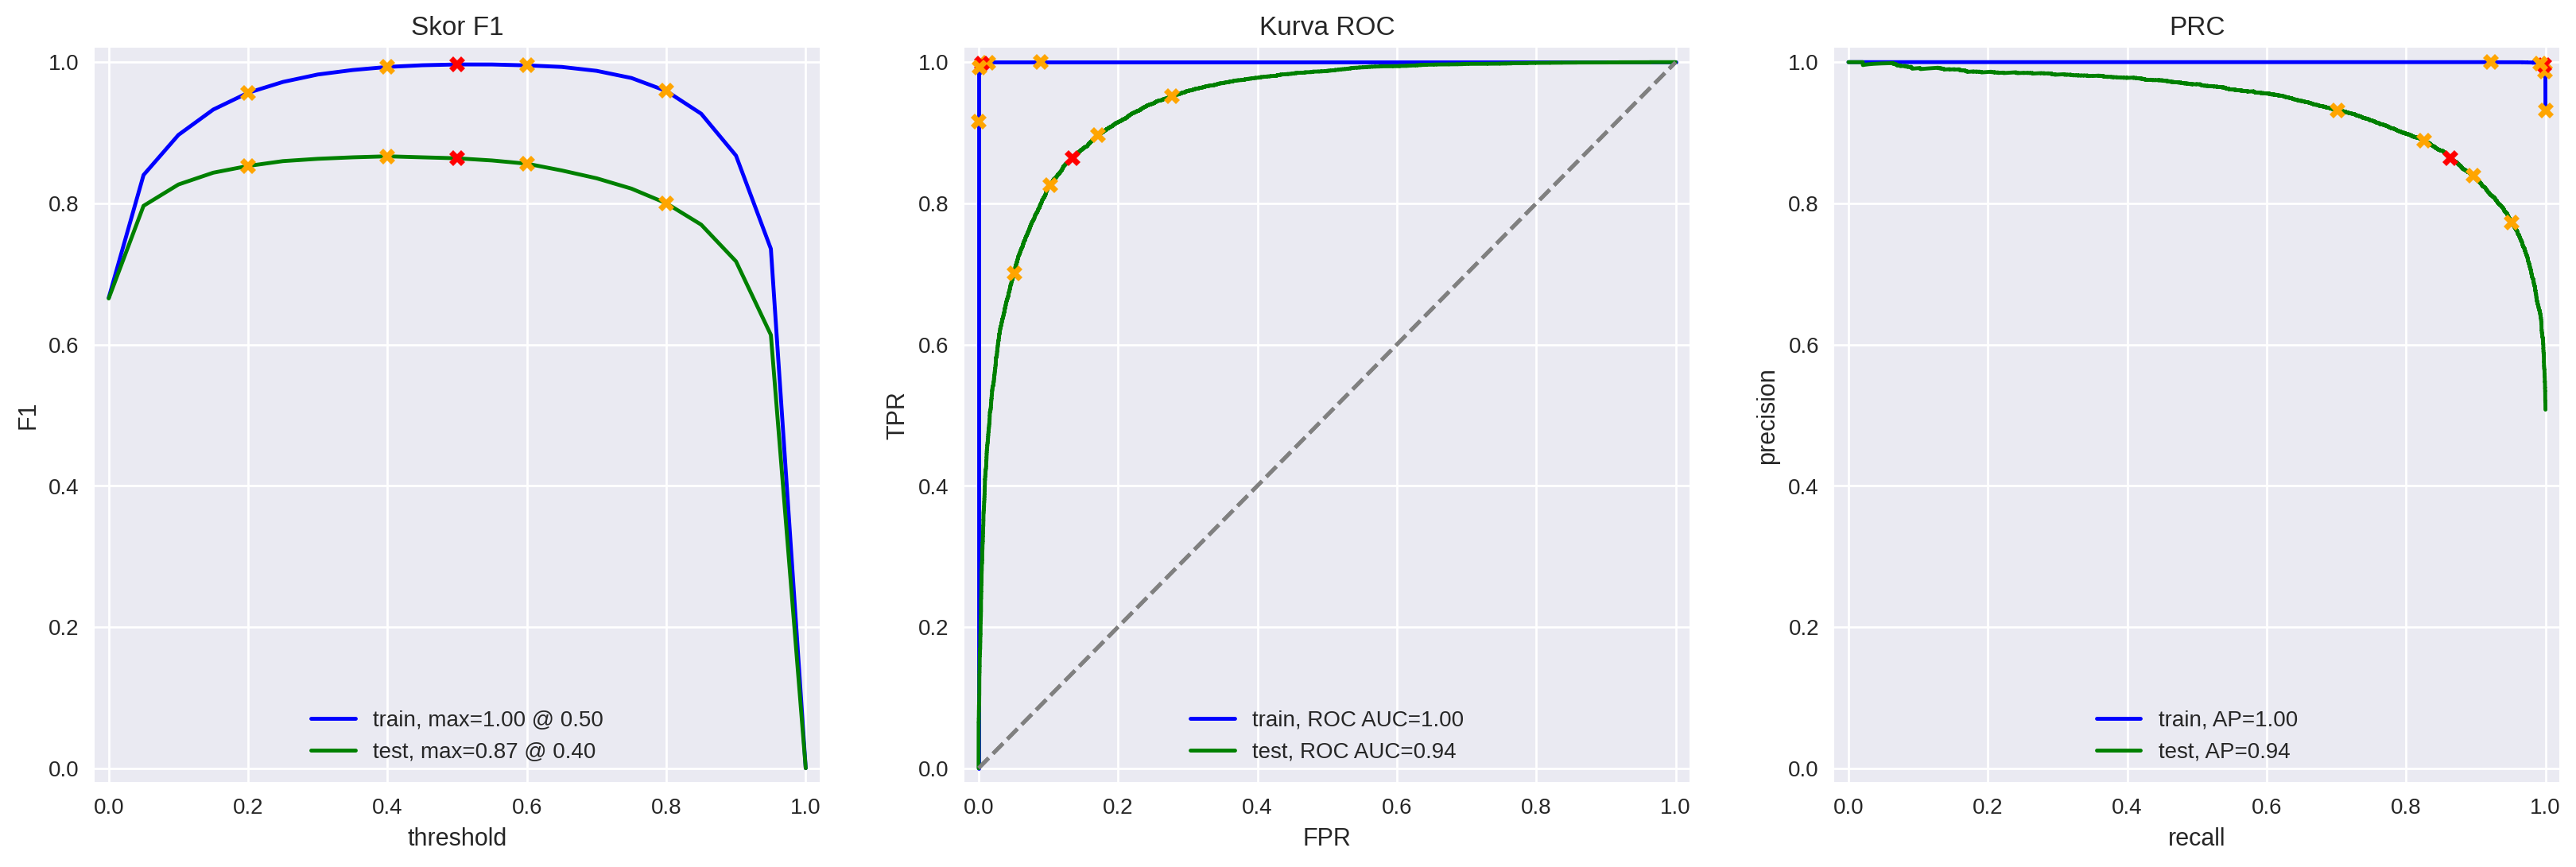

In [37]:
# melatih model LGBMClassifier
model_lgbm = LGBMClassifier(learning_rate=0.2,n_estimators=250)
model_lgbm.fit(train_features_2,train_target)

# mengevaluasi model-3 LGBMClassifier
eval_4 = evaluate_model(model_lgbm, train_features_2, train_target, test_features_2, test_target)

disini nilainya lebih baik daripada sebelumnya, untuk train memiliki nilai `1.0` sedangkan nilai testnya pada rentang `0.86`-`0.94`

###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
# mendefinisikan model, config, tokenizer dan jumlah sampel
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')
max_sample_size = 100

In [ ]:
# melakukan duplikasi dataset train
df_reviews_train = df_reviews_train.reset_index(drop=True).copy()
train_target = train_target.reset_index(drop=True).copy()

# membagi dataset training sebanyak 50 dengan proporsi kelas yang sama
df_reviews_train_1 = df_reviews_train[df_reviews_train['pos'] == 1]
df_reviews_train_0 = df_reviews_train[df_reviews_train['pos'] == 0]
train_bert = pd.concat([df_reviews_train_0[:int(max_sample_size/4)]['review_norm'],df_reviews_train_1[:int(max_sample_size/4)]['review_norm']],axis=0)
target_train_bert = df_reviews_train.iloc[train_bert.index].copy()
target_train_bert['pos'].value_counts()

In [ ]:
# melakukan duplikasi dataset test
df_reviews_test = df_reviews_test.reset_index(drop=True).copy()
test_target = test_target.reset_index(drop=True).copy()

# membagi dataset training sebanyak 50 dengan proporsi kelas yang sama
df_reviews_test_1 = df_reviews_test[df_reviews_test['pos'] == 1]
df_reviews_test_0 = df_reviews_test[df_reviews_test['pos'] == 0]
test_bert = pd.concat([df_reviews_test_0[:int(max_sample_size/4)]['review_norm'],df_reviews_test_1[:int(max_sample_size/4)]['review_norm']],axis=0)
target_test_bert = df_reviews_test.iloc[test_bert.index].copy()
target_test_bert['pos'].value_counts()

In [ ]:
# menggabungkan dataset train dan test
features_bert = pd.concat([train_bert,test_bert],axis=0)
target_bert = pd.concat([target_train_bert['pos'],target_test_bert['pos']],axis=0)

print(features_bert.shape)
print(target_bert.shape)

In [ ]:
# Memuat model dan tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Mendefinisikan fungsi untuk memproses teks menggunakan BERT
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    # Menggunakan batch tokenization dari tokenizer untuk efisiensi
    encoded_inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    input_ids = encoded_inputs['input_ids']
    attention_masks = encoded_inputs['attention_mask']

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using device: {device}')

    # Dapatkan embedding dalam batch
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(input_ids), batch_size), disable=disable_progress_bar):
            ids_batch = input_ids[i:i+batch_size].to(device)
            attention_mask_batch = attention_masks[i:i+batch_size].to(device)
            outputs = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)
    
    return np.concatenate(embeddings, axis=0)

In [ ]:
# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
transformed_features_bert = BERT_text_to_embeddings(features_bert)

In [ ]:
# membagi dataset yang sudah dilakukan prapemrosesan menggunakan BERT menjadi train dan test dengan jumlah kelas ulasan yang seimbang
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(transformed_features_bert,target_bert,test_size=0.2,stratify=target_bert,random_state=42)

print(y_train_bert.value_counts())
print(y_test_bert.value_counts())

In [ ]:
# melatih model logistic regression
model_4 = LogisticRegression()
model_4.fit(X_train_bert,y_train_bert)

# mengevaluasi model-4 LogisticRegression
eval_5 = evaluate_model(model_4, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

In [ ]:
# jika sudah mendapatkan embedding, disarankan untuk menyimpannya agar siap 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# dan muat...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [ ]:
# memuat hasil dari features_4.npz
with np.load('features_4.npz') as data:
    large_features_bert = data['train_features']
    large_target_bert = data['test_features']

print(large_features_bert.shape)
print(large_target_bert.shape)

In [ ]:
# membagi dataset yang sudah dilakukan prapemrosesan menggunakan BERT menjadi train dan test dengan jumlah kelas ulasan yang seimbang
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(large_features_bert,large_target_bert,test_size=0.2,stratify=large_target_bert,random_state=42)

# melatih model logistic regression
model_5 = LogisticRegression()
model_5.fit(X_train_bert,y_train_bert)

# mengevaluasi model-5 LogisticRegression
eval_9 = evaluate_model(model_5, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

sayang sekali model ini sering kali menyebabkan dead kernel, sehingga diputuskan tidak melanjutkan menggunakan model ini.

### Komperasi model

Konstan(Dummy)
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5

NLTK, TF-IDF dan LR
          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95

spaCy, TF-IDF dan LR
          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.94
ROC AUC    0.98  0.95

spaCy, TF-IDF dan LGBM
          train  test
Accuracy    1.0  0.86
F1          1.0  0.86
APS         1.0  0.94
ROC AUC     1.0  0.94


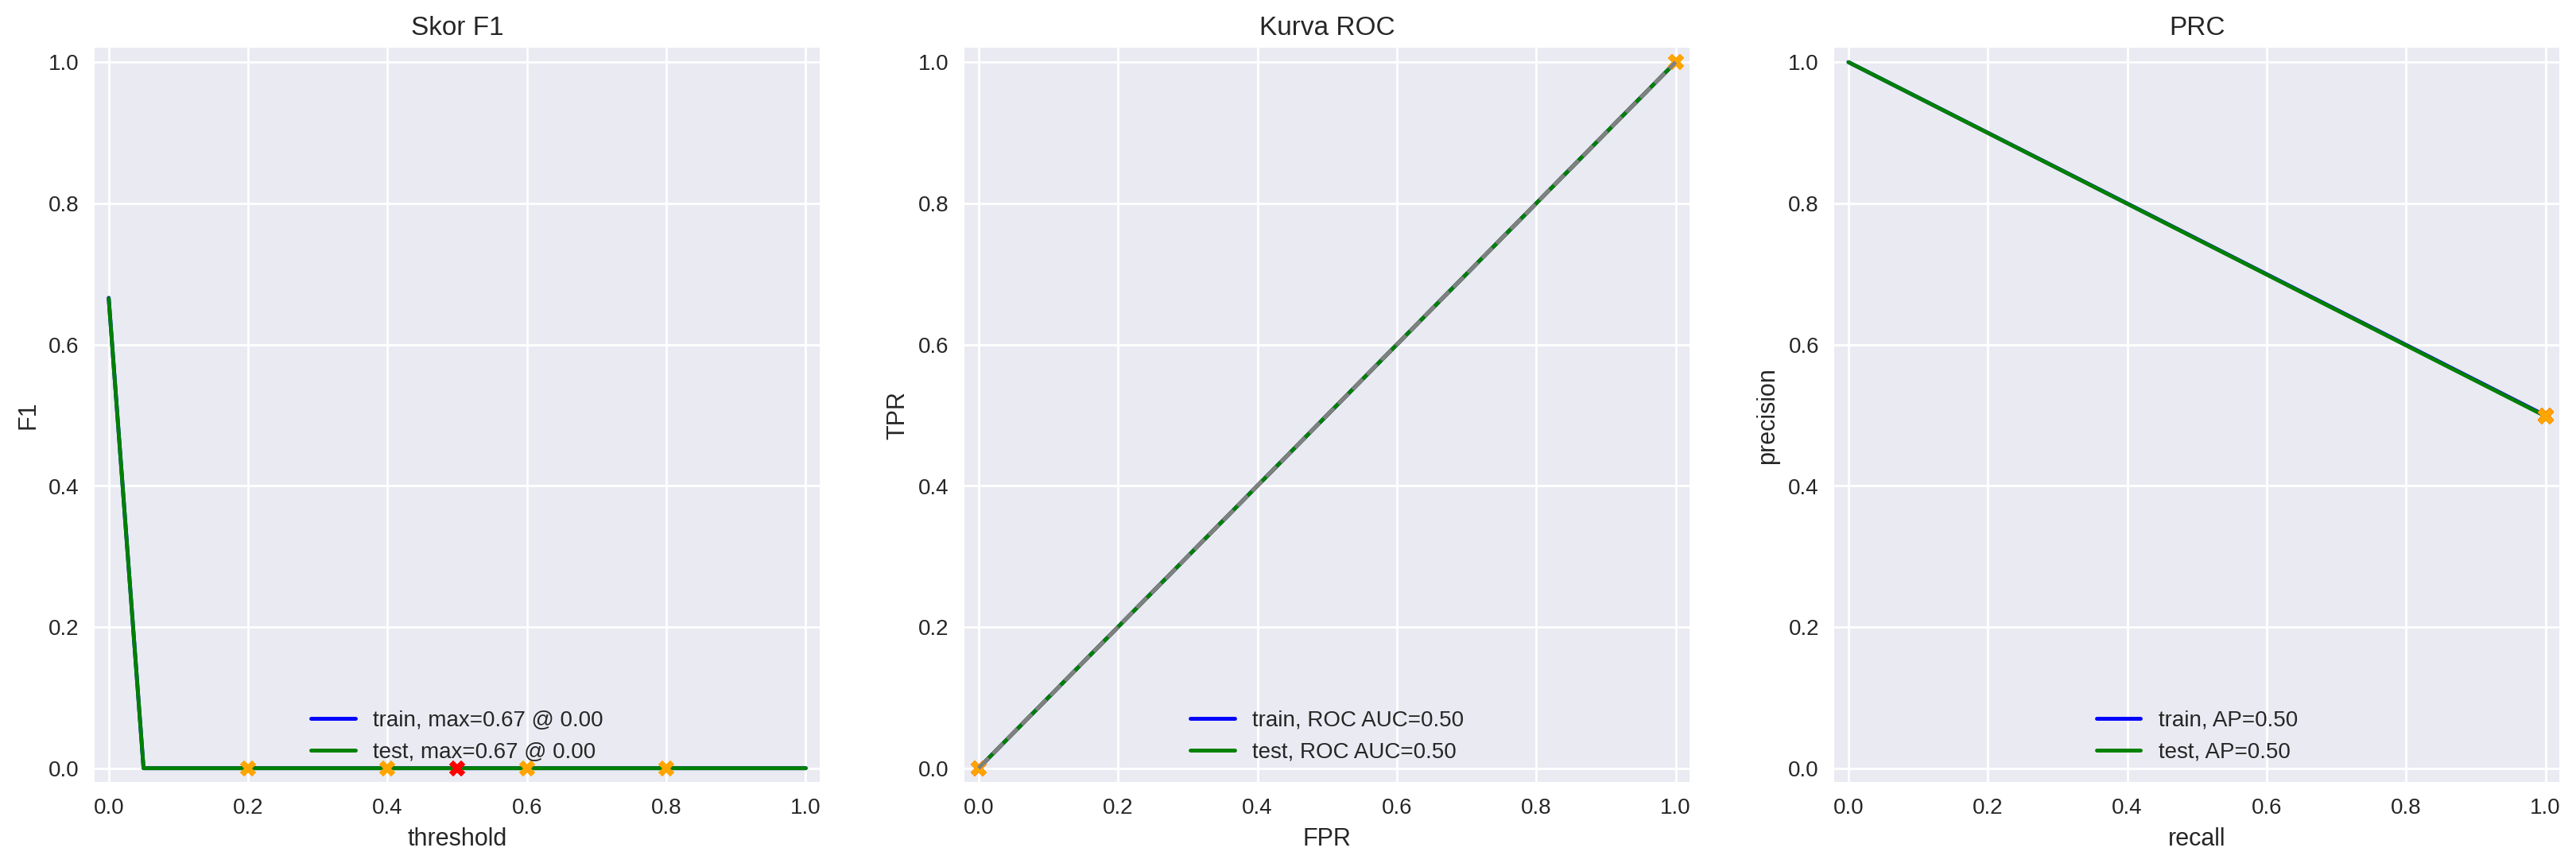

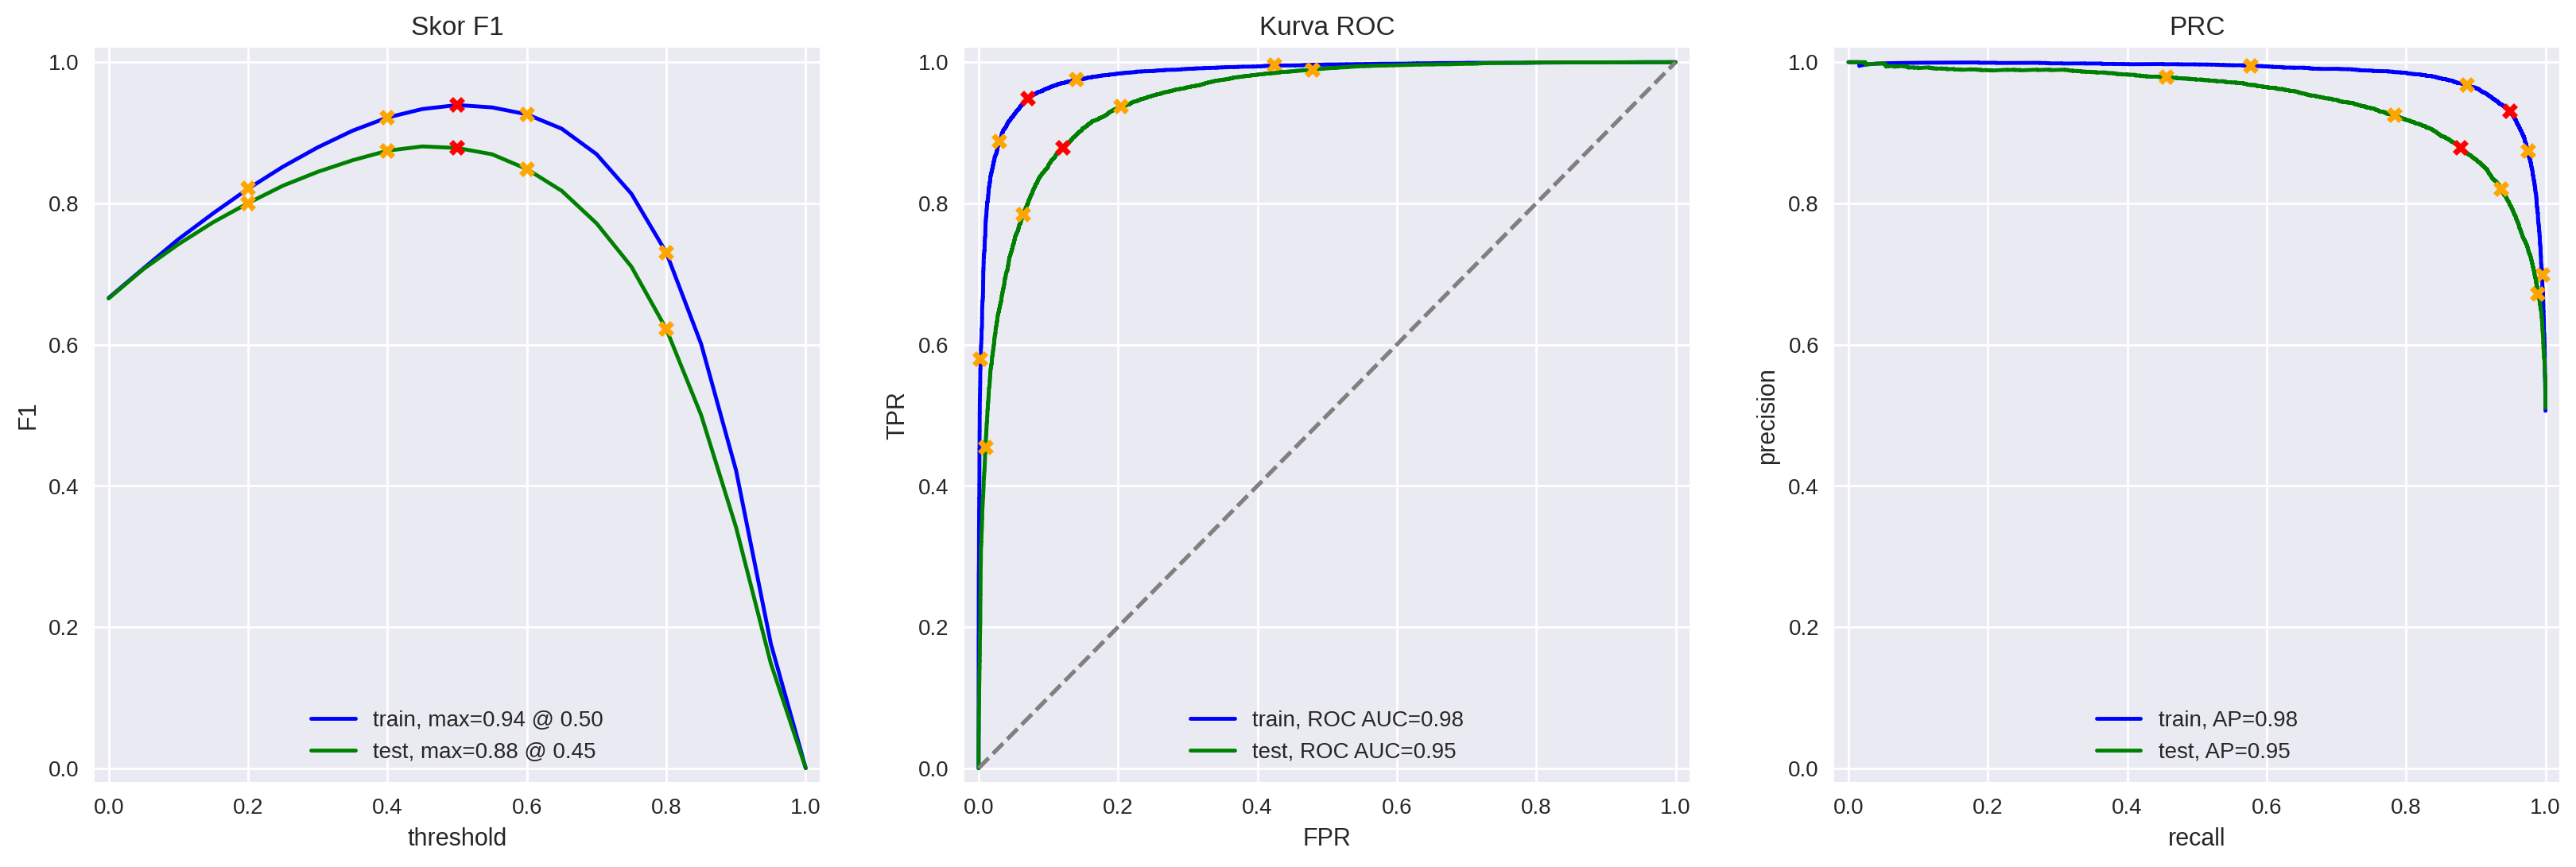

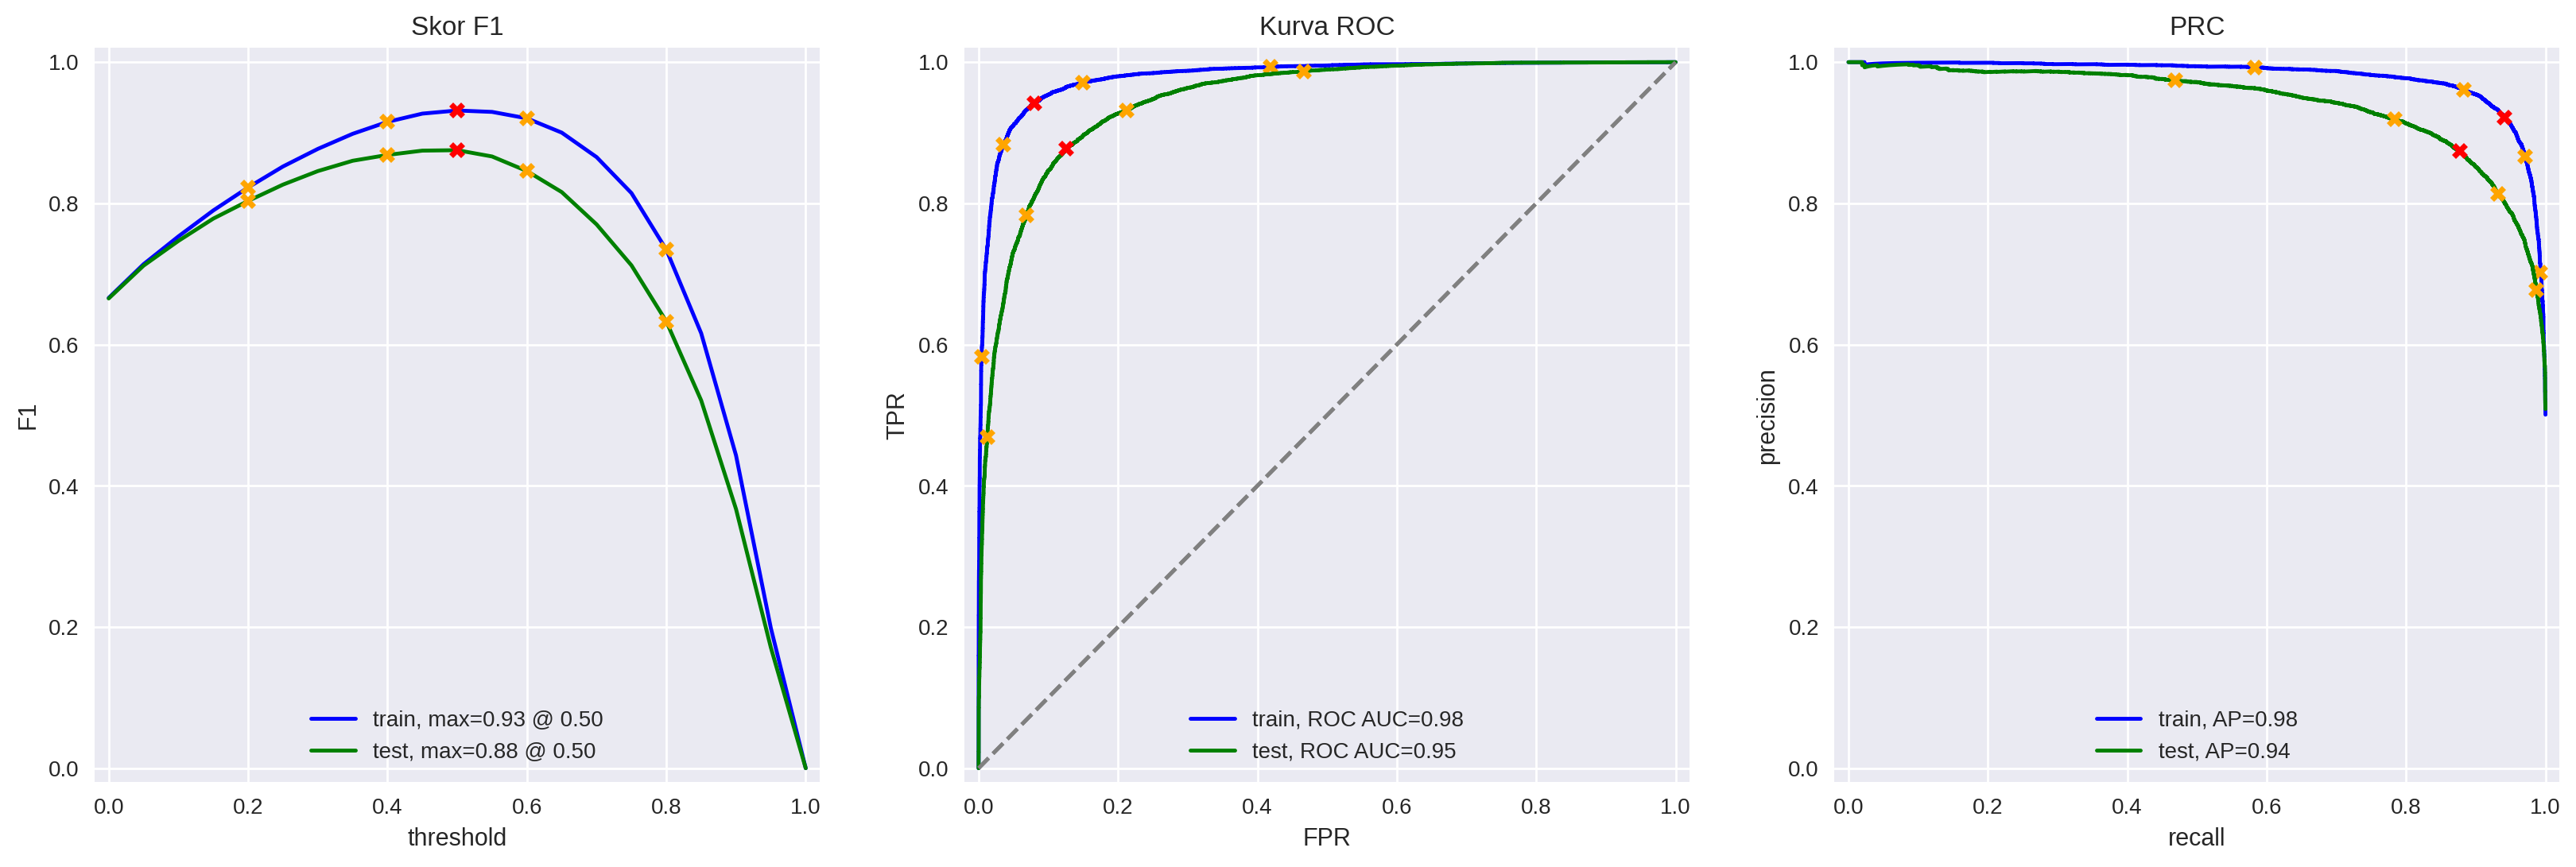

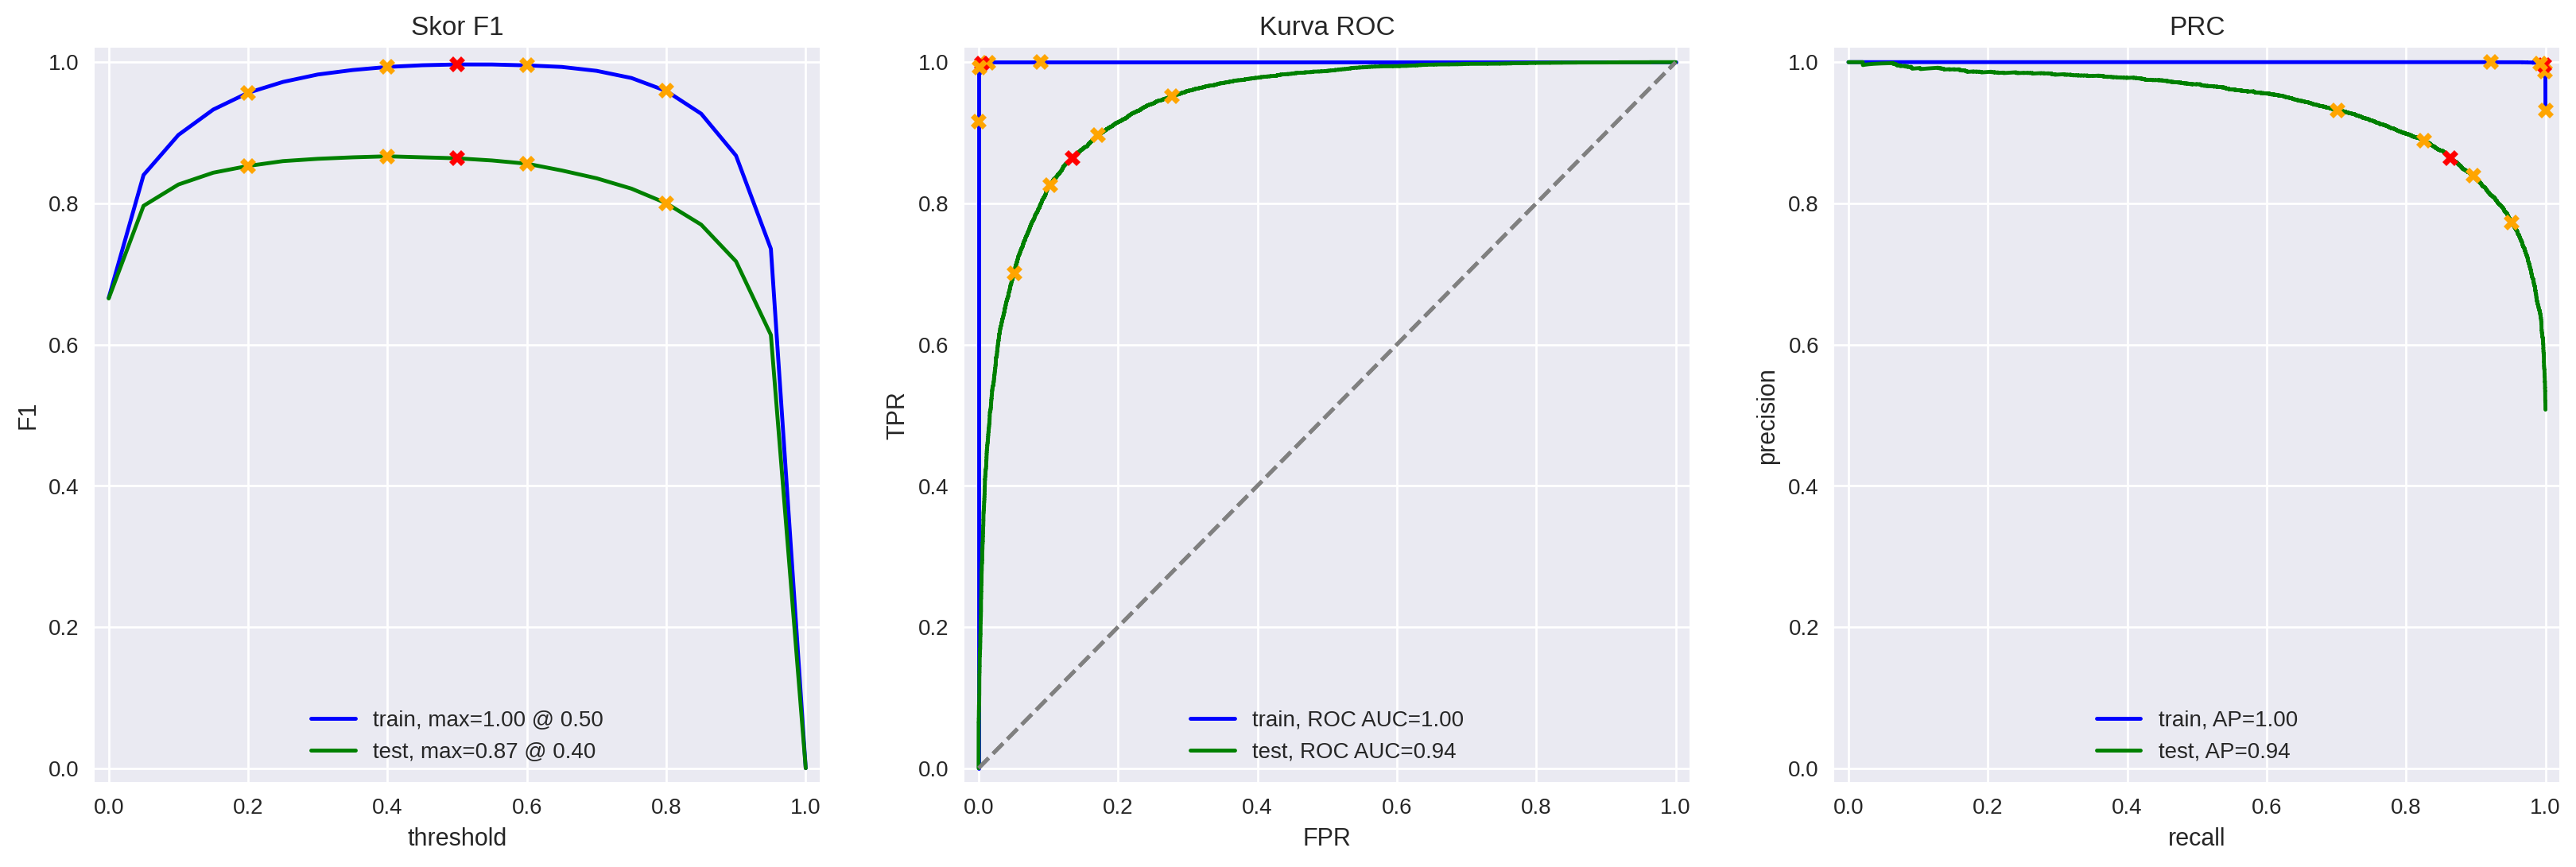

In [40]:
# Evaluasi model dummy
print('Konstan(Dummy)')
eval_0 = evaluate_model(model_dummy, x_train, train_target, x_test, test_target)

# Evaluasi model logistic regression
print('\nNLTK, TF-IDF dan LR')
eval_1 = evaluate_model(model_lr, train_tfidf, train_target, test_tfidf, test_target)

# Evaluasi model logistic regression dengan preprocessing kedua
print('\nspaCy, TF-IDF dan LR')
eval_3 = evaluate_model(model_lr2, train_features_2, train_target, test_features_2, test_target)

# Evaluasi model LightGBM
print('\nspaCy, TF-IDF dan LGBM')
eval_4 = evaluate_model(model_lgbm, train_features_2, train_target, test_features_2, test_target)

**Kesimpulan:** Bisa kita simpulkan bahwa beberapa model yang kita latih dan uji lolos terhadap skor yang kita tetapkan yaitu F1 >= 0.85. Model-model yang lolos diantaranya model-1, model-3, dan model-4. Jika model kita urutkan dari yang terbaik menuju yang terbaik dengan mempertimbangkan skor dan adanya tanda-tanda overfit: model-1 > model-3 > model-4.

## Ulasan Saya

In [41]:
# ulasan yang dibuat
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# melakukan normalisasi teks
my_reviews['review_norm'] = my_reviews['review'].apply(pre_text)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


dapat kita lihat bahwa ulasan positif terdapat pada index `[2,4,7]` sedangkan komentar negatif terdapat pada index `[0,1,3,6]` dan komentar yang tergolong netral yaitu index `[5]` sekarang kita akan mengaplikasikannya terhadap model sebelumnya.

### Model 2

In [42]:
# pengujian pada model-1
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_lr.predict_proba(tfidf.transform(texts))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.09:  i did not simply like it not my kind of movie
0.06:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.18:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.24:  i didn t expect the reboot to be so good writers really cared about the source material
0.43:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


terlihat bahwa akurasi penilaian terhadap index positif `[2,4,7,5]` memperlihatkan rentang `0.24-0.88` dan ulasan negatif index `[0,1,3,6]` memperlihatkan rentang `0.04-0.19` yang mana memiliki rentang yang cukup jauh jika dibandingkan dengan ulasan positif. menggunakan model ini akurasi penilaian ulasan memiliki rentang nilai `0.04-0.88`. model ini juga membuktikan ketidak akurasian penilaian baik untuk review positif maupun negatif.

### Model 3

In [43]:
# pengujian pada model-3
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_lr2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.35:  i did not simply like it not my kind of movie
0.25:  well i was bored and felt asleep in the middle of the movie
0.51:  i was really fascinated with the movie
0.44:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.43:  i didn t expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.17:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.86:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


terlihat bahwa akurasi penilaian terhadap index positif `[2,4,7,5]` memperlihatkan rentang `0.43-0.86` dan ulasan negatif index `[0,1,3,6]` memperlihatkan rentang `0.17-0.44` yang mana memiliki rentang yang cukup jauh jika dibandingkan dengan ulasan positif. menggunakan model ini akurasi penilaian ulasan memiliki rentang nilai `0.17-0.86`. ini cukup baik dibandingkan dengan model sebelumnya.

### Model 4

In [44]:
# pengujian pada model-4
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_lgbm.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.57:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.08:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


terlihat bahwa akurasi penilaian terhadap index positif `[2,4,7,5]` memperlihatkan rentang `0.31-0.89` dan ulasan negatif index `[0,1,3,6]` memperlihatkan rentang `0.08-0.19` yang mana memiliki rentang yang jauh berbeda dengan ulasan positif. menggunakan model ini akurasi penilaian ulasan memiliki rentang nilai `0.08-0.89`. akurasi ini tidak jauh berbeda dengan model 1, masih tidak dapat mendeteksi komentar negatif dengan baik, dan juga memiliki akurasi yang rendah

## Kesimpulan

1. dataset memperlihatkan bahwa setiap tahun terjadi peningkatan perilisan dan review dari film. kritik yang dihasilkan beragam, secara nilai positif dan negatif memiliki nilai kesetimbangan yang sama. dataset train dan test pun seimbang antara positif dan negatif, sehingga lebih memudahkan untuk proses selanjutnya.
2. Bisa kita simpulkan bahwa beberapa model yang kita latih dan uji lolos terhadap skor yang kita tetapkan yaitu F1 >= 0.85. Model-model yang lolos diantaranya model-1, model-3, dan model-4. Jika model kita urutkan dari yang terbaik menuju yang terbaik dengan mempertimbangkan skor dan adanya tanda-tanda overfit: model-1 > model-3 > model-4.
3. model terbaik dalam akurasi mendekati nilai ulasan adalah model-3

### Temuan

1. dataset terdiri dari 17 kolom dengan 47331, terlihat bahwa ada beberapa nilai yang hilang, tapi tidak terlalu banyak, ada kolom dengan tipe data yang salah `runtime_minutes`. tipe data pada kolom `runtime_minutes` tidak dapat langsung diubah karena memiliki nilai `\\N` yang sulit di definisikan
2. data memiliki huruf besar kecil dan beberapa tanda baca yang akan menyulitkan proses selanjutnya
3. model `BERT` sering kali menyebabkan dead kernel sehingga tidak disarankan untuk digunakan

### Rekomendasi

Misi utamanya adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Model ini setidaknya harus memiliki skor F1 sebesar 0,85. dari hasil yang telah didapatkan model terbaik dalam mendeteksi komentar negatif adalah model `spaCy, TF-IDF dan LR` karena tingkat akurasinya bisa mencapai diatas 44% dan nilai `f1` train mencapai `0.93` dan test `0.88`. meskipun model ini masih kurang sempurna, tapi ini lebih baik dibandingkan dengan model-model lainnya.